# Summary: South Asian Cancer Cohort - Clinical and Genomic Analysis

This Jupyter notebook performs a comprehensive analysis of clinical and genomic data from South Asian cancer patients. The workflow integrates patient demographics, comorbidities, genomic variants, and association studies to provide insights into cancer prevalence, morbidity patterns, and genetic risk factors. The notebook combines data preprocessing, statistical analysis, and high-quality visualizations for publication-ready figures.


Imports

In [ ]:
# Core data handling and manipulation
import pandas as pd
import os
import re

# Date and time utilities
from datetime import datetime
from dateutil import relativedelta

# Numerical operations
import numpy as np
import math

# For invoking external commands when needed
import subprocess

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from plotly.subplots import make_subplots


Utility functions

In [2]:

def read_csv(file_name, delimiter = ',', chunksize = 10000, na_filter = False) :
    """
    Generator that streams a CSV file in chunks to reduce memory usage.
    
    Parameters:
        file_name (str): Path to the CSV file.
        delimiter (str): Character separating columns.
        chunksize (int): Number of rows per chunk.
        na_filter (bool): Whether to detect missing values. 
                          Set to False for speed when NA detection isn’t needed.
                          
    Yields:
        pandas.DataFrame: Chunk of the CSV file.
    """
    for chunk in pd.read_csv(file_name, chunksize=chunksize, delimiter=delimiter, na_filter=na_filter):
        yield chunk

def createDate(str, fmt="%Y-%m-%d"):
    """
    Safely convert a string into a Python datetime object.
    
    Parameters:
        str (str): Date string.
        fmt (str): Expected date format (default: YYYY-MM-DD).
        
    Returns:
        datetime or None: Parsed datetime object, or None if parsing fails.
    """
    try:
        return datetime.strptime(str, fmt)
    except:
        return None

def num_to_range(x, thresholds):
  """
    Convert a numeric value into a categorical range based on threshold cutoffs.
    
    Parameters:
        x (float): Numeric value to categorize.
        thresholds (list[int]): Increasing list defining range boundaries.
        
    Returns:
        str or None: Range label (e.g., "1–10"), or None if x is NaN.
  """
  if(math.isnan(x)):
    return None
  i=1
  while i < len(thresholds):
    if(int(x)<=thresholds[i]):
        return f"{thresholds[i-1]+1}-{thresholds[i]}"
    i += 1
  return f"{thresholds[i-1]}+"

def q1(x):
    """
    Compute the first quartile (25th percentile) of a numeric Series.
    """
    return x.quantile(0.25)

def q3(x):
    """
    Compute the third quartile (75th percentile) of a numeric Series.
    """
    return x.quantile(0.75)


Assign directory paths

In [ ]:
result_path = "input/"
text_path = "output/text/"
plot_path = "output/plots/"
manhattan_path = "input/manhattan-data/"


#### Visualise various baseline summary characteristics

Cancer prevalence barplot with overlay

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/474458084.py:37: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



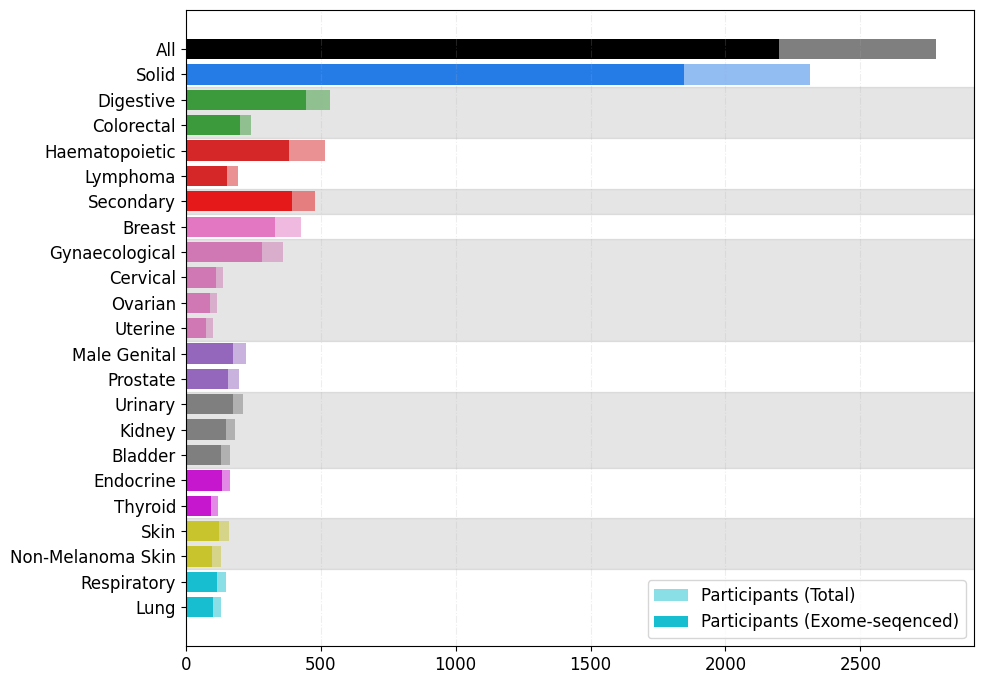

In [54]:
# Cancer groups to visualise
cancer_dict = ['All','Solid','Digestive','Colorectal','Haematopoietic','Lymphoma','Breast','Gynaecological','Ovarian', 'Uterine', 'Cervical',
            'Male Genital','Prostate', 'Urinary','Kidney', 'Bladder','Skin', 'Non-Melanoma Skin', 'Endocrine','Thyroid','Respiratory','Lung',"Secondary"]     

# Color assgnnment for each aggregated and individual cancer groups
colors = ["#000000","#267CE6", '#2ca02c','#2ca02c','#d62728','#d62728',
          '#e377c2','#e377c2','#e377c2','#e377c2','#e377c2',
         '#9467bd','#9467bd', '#7f7f7f','#7f7f7f', '#7f7f7f', 
         "#d9d619", "#d9d619", "#c617cf","#c617cf", '#17becf','#17becf','#ff0000']

traits = [v.replace('_', ' ') for v in cancer_dict]
color_map = dict(zip(traits,colors))

# Load cancer prevalence summary (patients vs exome-sequenced samples)
df = pd.read_csv(result_path + "baseline" + "/cancer_prevalence.csv", header=0)

# Set global plot font size
plt.rcParams['font.size'] = 12

# Overlaying barplot: Number of samples (Exome_count) on top of number of patients (Size)
plt.figure(figsize=(10, 7))
cancers = df["Cancer"].fillna("Break")
patients = df["Size"]
samples = df["Exome_count"]
bar_colors = [color_map.get(c, "#333333") for c in cancers]

# Base layer: total participants
plt.barh(cancers, patients, color=bar_colors, alpha=0.5, label="Participants (Total)")

# Overlay: exome-sequenced subset
plt.barh(cancers, samples, color=bar_colors, alpha=1.0, label="Participants (Exome-seqenced)")


# Highlight specific groups of cancer types using shaded horizontal spans
group = [(2,3), (6,8), (11,14), (16,16), (19,20)]
for start, end in group:
    plt.axhspan(start-0.5, end+0.5, color='grey', alpha=0.2, edgecolor='none')  # Shade between y=start and y=end

plt.grid(visible=True, axis='x',color='#aaa',linestyle='-.', alpha=0.2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=0)
plt.legend()
plt.title(None)
plt.tight_layout()
plt.savefig(plot_path+ "publication/baseline" + "/cancer_prevalence.png", dpi=600)
plt.show()

Cancer dictionary definitions

In [55]:
mode = "custom"
# Mapping aggregated cancer categories to readable labels
cancer_dict_agg = { 'Digestive' : 'Digestive', 'Urinary' : 'Urinary', 'bone_and_articular_cartilage' : 'Bone', 'Adult_Solid': 'Solid',
               'CNS' : 'CNS', 'Respiratory' : 'Respiratory', 'Gynaecological': 'Gynaecological', 'Secondary': 'Secondary', 
               'Male_Genital' : 'Male genital', 'Endocrine' : 'Endocrine','Blood_and_Lymph':'Haematopoietic', 'All': 'All'}

# Mapping individual cancer types to readable labels
cancer_dict_ind = { 'Oro-pharyngeal': 'Oro-pharyngeal','Other_Skin_and_subcutaneous_tissue' : 'Non-Melanoma Skin', 'Skin' : 'Skin', 'biliary_tract': 'Biliary tract', 
                   'bladder' : 'Bladder', 'bone_and_articular_cartilage' : 'Bone', 'breast' : 'Breast', 'cervical' : 'Cervical',
              'pancreatic': 'Pancreatic', 'prostate' : 'Prostate','colorectal_and_anus' : 'Colorectal', 'kidney_and_ureter' : 'Kidney', 'liver' : 'Liver',
              'stomach' : 'Stomach', 'testicular' : 'Testicular', 'thyroid' : 'Thyroid', 'uterine' : 'Uterine', 'ovarian': 'Ovarian',
              'lung_and_trachea' : 'Lung', 'malignant_melanoma' : 'Melanoma', 'mesothelioma' : 'Mesothelioma','oesophageal' : 'Oesophageal',
              'Leukaemia':'Leukaemia','Multiple_myeloma_and_malignant_plasma_cell_neoplasms':'Myeloma', 'Lymphoma':'Lymphoma'
              }
# Combine aggregated + individual mappings
cancer_dict = cancer_dict_agg | cancer_dict_ind
# Set of cancer types for downstream filtering / grouping
cancer_group = cancer_dict.keys()

Load baseline characteristics dataset

In [56]:
# Assumes path structure: <result_path>/comorbidity/baseline.sas-bp.txt
incidence=pd.read_csv(result_path+"baseline"+"/baseline.sas-bp.txt",sep="\t")

# Standardise terminology to match dictionary structure
incidence["Cancer"] = incidence["Cancer"].replace({"Haematological":"Haematopoietic"})
incidence_orig = incidence.copy()

Gender-based Cancer Prevalence Plot (Aggregate)

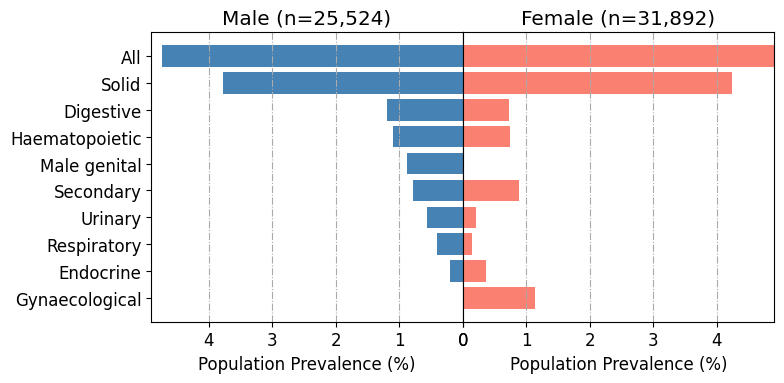

In [57]:
# Filter aggregated cancer group data to include only predefined cancer groups
incidence = incidence_orig[incidence_orig["Cancer"].isin(cancer_dict_agg.values())]

# Inspect rows related to gender category
incidence[incidence["Category"]=="Gender"]

# Pivot gender data to create a table with cancer types vs. gender-specific counts and proportions
agg_gender = incidence[incidence["Category"]=="Gender"].pivot(index="Cancer", columns="Value", values=["Count","Prop"])
agg_gender.dropna(axis=1, how='all', inplace=True)
agg_gender.fillna(0, inplace=True)
agg_gender.reset_index(inplace=True)
agg_gender.sort_values(by=('Prop','Male'), inplace=True)

# Create side-by-side horizontal bar plots for male and female prevalence
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)

male = incidence[(incidence["Category"]=="Gender") & (incidence["Value"]=="Male")].iloc[0,2]
female = incidence[(incidence["Category"]=="Gender") & (incidence["Value"]=="Female")].iloc[0,2]
# Left plot: Male prevalence (x-axis reversed for mirrored effect)
axes[0].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Male')], color='steelblue')
axes[0].set_title(f'Male (n={male:,d})')
axes[0].set_xlim(round(agg_gender["Prop"].values.max(),1),0)
axes[0].set_xlabel('Population Prevalence (%)')
axes[0].xaxis.set_inverted(True)
axes[0].grid(visible=True, axis='x',color='#aaa',linestyle='-.')
# Right plot: Female prevalence
axes[1].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Female')], color='salmon')
axes[1].set_title(f'Female (n={female:,d})')
axes[1].set_xlim(0,round(agg_gender["Prop"].values.max(),1))
axes[1].set_xlabel('Population Prevalence (%)')
axes[1].grid(visible=True, axis='x',color='#aaa',linestyle='-.')

axes[0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
axes[1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
axes[1].yaxis.set_visible(False)


plt.tight_layout()
plt.subplots_adjust(wspace=0)

plt.savefig(plot_path+"publication/baseline"+"/cancerbygender_pop_agg.png", bbox_inches='tight', dpi=300, transparent=True)

Gender-based Cancer Prevalence Plot (Individual)

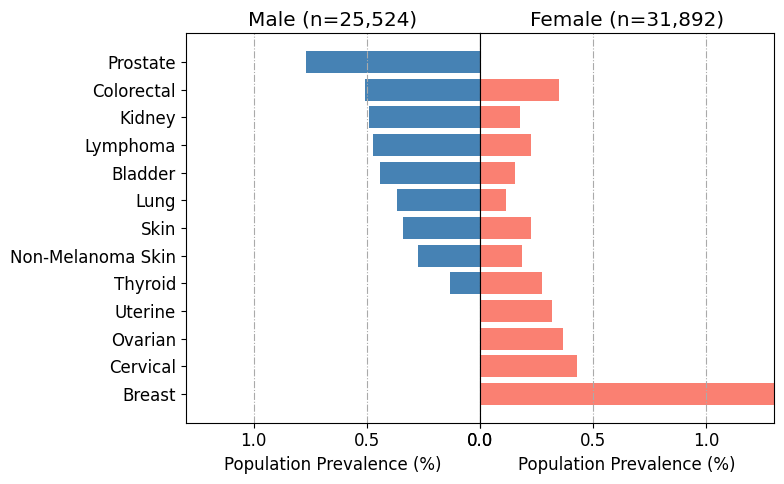

In [63]:
# Filter indiviudal cancer group data to include only predefined cancer groups
incidence = incidence_orig[incidence_orig["Cancer"].isin(cancer_dict_ind.values())]

# Inspect rows related to gender category
incidence[incidence["Category"]=="Gender"]

# Pivot gender data to create a table with cancer types vs. gender-specific counts and proportions
agg_gender = incidence[incidence["Category"]=="Gender"].pivot(index="Cancer", columns="Value", values=["Count","Prop"])
agg_gender.dropna(axis=1, how='all', inplace=True)
agg_gender.fillna(0, inplace=True)
agg_gender.reset_index(inplace=True)
agg_gender.sort_values(by=('Prop','Male'), inplace=True)

# Create side-by-side horizontal bar plots for male and female prevalence
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)

male = incidence[(incidence["Category"]=="Gender") & (incidence["Value"]=="Male")].iloc[0,2]
female = incidence[(incidence["Category"]=="Gender") & (incidence["Value"]=="Female")].iloc[0,2]
# Left plot: Male prevalence (x-axis reversed for mirrored effect)
axes[0].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Male')], color='steelblue')
axes[0].set_title(f'Male (n={male:,d})')
axes[0].set_xlim(round(agg_gender["Prop"].values.max(),1),0)
axes[0].set_xlabel('Population Prevalence (%)')
axes[0].xaxis.set_inverted(True)
axes[0].grid(visible=True, axis='x',color='#aaa',linestyle='-.')
# Right plot: Female prevalence
axes[1].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Female')], color='salmon')
axes[1].set_title(f'Female (n={female:,d})')
axes[1].set_xlim(0,round(agg_gender["Prop"].values.max(),1))
axes[1].set_xlabel('Population Prevalence (%)')
axes[1].grid(visible=True, axis='x',color='#aaa',linestyle='-.')

axes[0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
axes[1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
axes[1].yaxis.set_visible(False)


plt.tight_layout()
plt.subplots_adjust(wspace=0)

plt.savefig(plot_path+"publication/baseline"+"/cancerbygender_pop_ind.png", bbox_inches='tight', dpi=300, transparent=True)

Ethnicity-based Cancer Prevalence Plot (Aggregate)

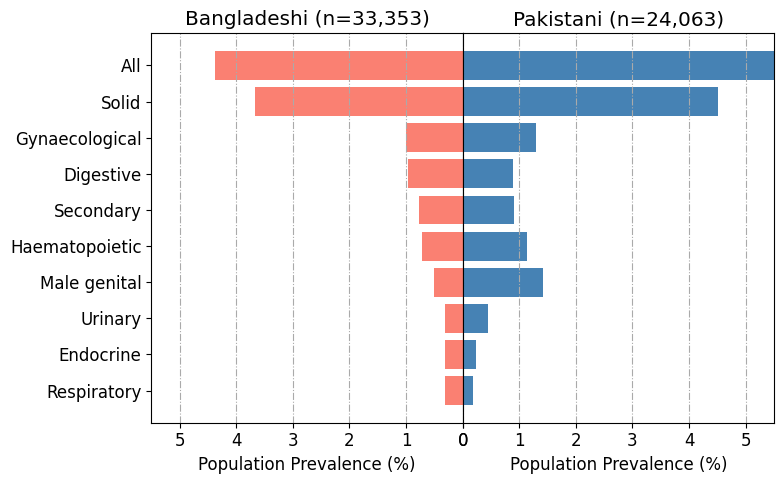

In [ ]:
incidence = incidence_orig[incidence_orig["Cancer"].isin(cancer_dict_agg.values())]

agg_gender = incidence[incidence["Category"]=="Ethnicity"].pivot(index="Cancer", columns="Value", values=["Count","Prop"])
agg_gender.dropna(axis=1, how='all', inplace=True)
agg_gender.fillna(0, inplace=True)
agg_gender.reset_index(inplace=True)
agg_gender.sort_values(by=('Prop','Bangladeshi'), inplace=True)

# Create side-by-side horizontal bar plots for Bangladeshi and Pakistani prevalence
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)

bd = incidence[(incidence["Category"]=="Ethnicity") & (incidence["Value"]=="Bangladeshi")].iloc[0,2]
pak = incidence[(incidence["Category"]=="Ethnicity") & (incidence["Value"]=="Pakistani")].iloc[0,2]

# Left plot: Bangladeshi prevalence (x-axis reversed for mirrored effect)
axes[0].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Bangladeshi')], color='salmon')
axes[0].set_title(f'Bangladeshi (n={bd:,d})')
axes[0].set_xlim(round(agg_gender["Prop"].values.max(),1),0)
axes[0].set_xlabel('Population Prevalence (%)')
axes[0].xaxis.set_inverted(True)
axes[0].grid(visible=True, axis='x',color='#aaa',linestyle='-.')

# Right plot: Pakistani prevalence
axes[1].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Pakistani')], color='steelblue')
axes[1].set_title(f'Pakistani (n={pak:,d})')
axes[1].set_xlim(0,round(agg_gender["Prop"].values.max(),1))
axes[1].set_xlabel('Population Prevalence (%)')
axes[1].grid(visible=True, axis='x',color='#aaa',linestyle='-.')

axes[0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
axes[1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
axes[1].yaxis.set_visible(False)



plt.tight_layout()
plt.subplots_adjust(wspace=0)

plt.savefig(plot_path+"publication/baseline"+"/cancerbyethnicity_pop_agg.png", bbox_inches='tight',dpi=300, transparent=True)

Ethnicity-based Cancer Prevalence Plot (Individual)

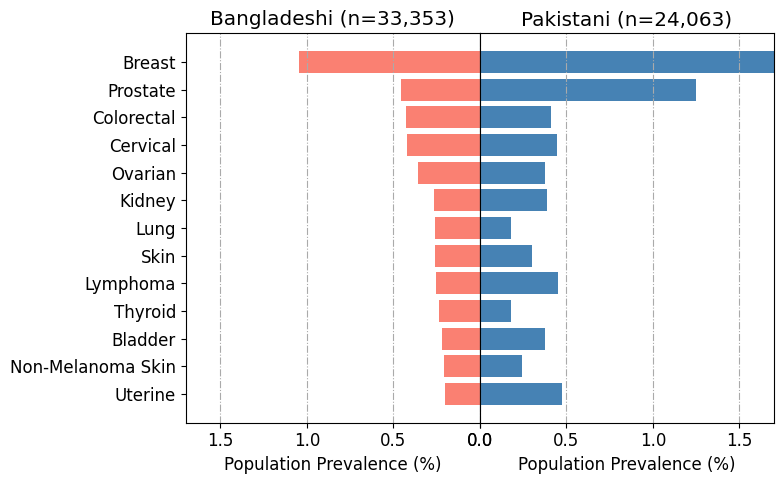

In [62]:
incidence = incidence_orig[incidence_orig["Cancer"].isin(cancer_dict_ind.values())]

agg_gender = incidence[incidence["Category"]=="Ethnicity"].pivot(index="Cancer", columns="Value", values=["Count","Prop"])
agg_gender.dropna(axis=1, how='all', inplace=True)
agg_gender.fillna(0, inplace=True)
agg_gender.reset_index(inplace=True)
agg_gender.sort_values(by=('Prop','Bangladeshi'), inplace=True)

# Create side-by-side horizontal bar plots for Bangladeshi and Pakistani prevalence
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)

bd = incidence[(incidence["Category"]=="Ethnicity") & (incidence["Value"]=="Bangladeshi")].iloc[0,2]
pak = incidence[(incidence["Category"]=="Ethnicity") & (incidence["Value"]=="Pakistani")].iloc[0,2]

# Left plot: Bangladeshi prevalence (x-axis reversed for mirrored effect)
axes[0].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Bangladeshi')], color='salmon')
axes[0].set_title(f'Bangladeshi (n={bd:,d})')
axes[0].set_xlim(round(agg_gender["Prop"].values.max(),1),0)
axes[0].set_xlabel('Population Prevalence (%)')
axes[0].xaxis.set_inverted(True)
axes[0].grid(visible=True, axis='x',color='#aaa',linestyle='-.')

# Right plot: Pakistani prevalence
axes[1].barh(agg_gender[('Cancer','')], agg_gender[('Prop','Pakistani')], color='steelblue')
axes[1].set_title(f'Pakistani (n={pak:,d})')
axes[1].set_xlim(0,round(agg_gender["Prop"].values.max(),1))
axes[1].set_xlabel('Population Prevalence (%)')
axes[1].grid(visible=True, axis='x',color='#aaa',linestyle='-.')

axes[0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
axes[1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
axes[1].yaxis.set_visible(False)



plt.tight_layout()
plt.subplots_adjust(wspace=0)

plt.savefig(plot_path+"publication/baseline"+"/cancerbyethnicity_pop_ind.png", bbox_inches='tight',dpi=300, transparent=True)

Ethnicity–Genetic Ancestry Concordance Plot

<Figure size 400x400 with 0 Axes>

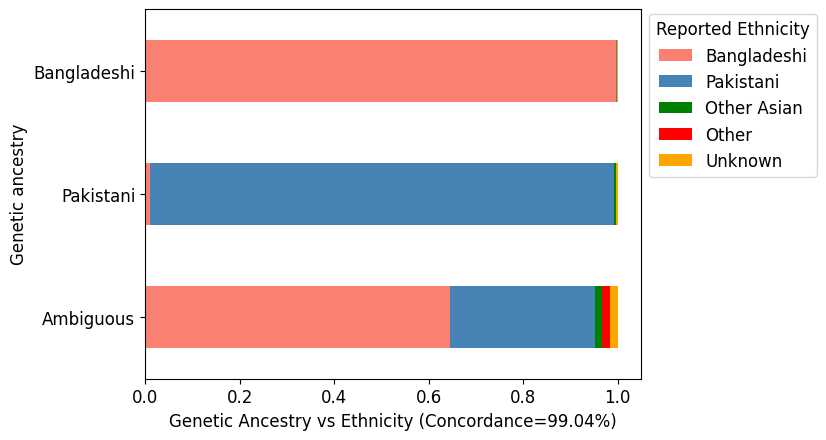

In [65]:
# Load ethnicity–genetic ancestry concordance table
eth_anc_mapping_prop = pd.read_csv(result_path+"baseline"+"/ethnicity_ancestry_mapping.prop.txt", header=0, sep='\t')
# Use ancestry labels as index for plotting
eth_anc_mapping_prop.set_index("Ancestry", inplace=True, drop=True)

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(4, 4))
colors = ['salmon','steelblue','green','red','orange']

# Create horizontal stacked bar plot comparing reported ethnicity vs genetic ancestry
ax = eth_anc_mapping_prop.plot(kind='barh', stacked=True, color=colors)
plt.xlabel("Genetic Ancestry vs Ethnicity (Concordance=99.04%)")
plt.ylabel("Genetic ancestry")
box = ax.get_position()

ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', title='Reported Ethnicity',
          fancybox=True, shadow=False)

plt.savefig(plot_path+"publication/baseline"+"/ethnicity-genancestry.png", bbox_inches='tight', dpi=300)

In [58]:
df = pd.read_csv(result_path + "phewas" + "/phewas_target_label.txt", sep='\t', na_filter=False, low_memory=False)
len(df["target"].unique())
df

,target,Phenotype,Marker,ALT_ID,CONSEQ
0,chr1_228414862_G_C_C,Prostate_Cancer,TRIM17 Q71E,TRIM17 Q71E,possMissense
1,chr1_228414862_G_C_C,Male_Genital_Cancer,TRIM17 Q71E,TRIM17 Q71E,possMissense
2,chr19_43997046_G_GA_GA,Prostate_Cancer,ZNF155 E397EX,ZNF155 E397EX,LoF
3,chr1_223268541_G_A_A,Lymphoma_Cancer,SUSD4 R166C,SUSD4 R166C,delMissense
4,chr4_56011912_A_C_C,Lung_Cancer,CEP135 E910A,CEP135 E910A,delMissense
...,...,...,...,...,...
74,TPRG1L.M2,Solid_Cancer,M2,TPRG1L.M2,lof_del
75,VNN2.M3,Cervical_Cancer,M3,VNN2.M3,lof_del_poss
76,ZBTB10.M3,Ovarian_Cancer,M3,ZBTB10.M3,lof_del_poss
77,ZNF155.M1,Prostate_Cancer,M1,ZNF155.M1,lof


In [ ]:
df = pd.read_csv(result_path + "phewas" + "/significant_phewas.csv", na_filter=False, low_memory=False)
df.drop(["X","Phenotype","Marker","ALT_ID"], axis=1, inplace=True)
df.shape
df.drop_duplicates(inplace=True)
df["snp"] = df["snp"].str.replace("_","-").str.replace("chr","",regex=False)
df["snp"] = df["snp"].apply(lambda x: "-".join(x.split("-")[:-1]) if "-" in x else x )
df.to_csv(result_path + "phewas" + "/significant_phewas_curated.csv", index=False)
df.head(20)

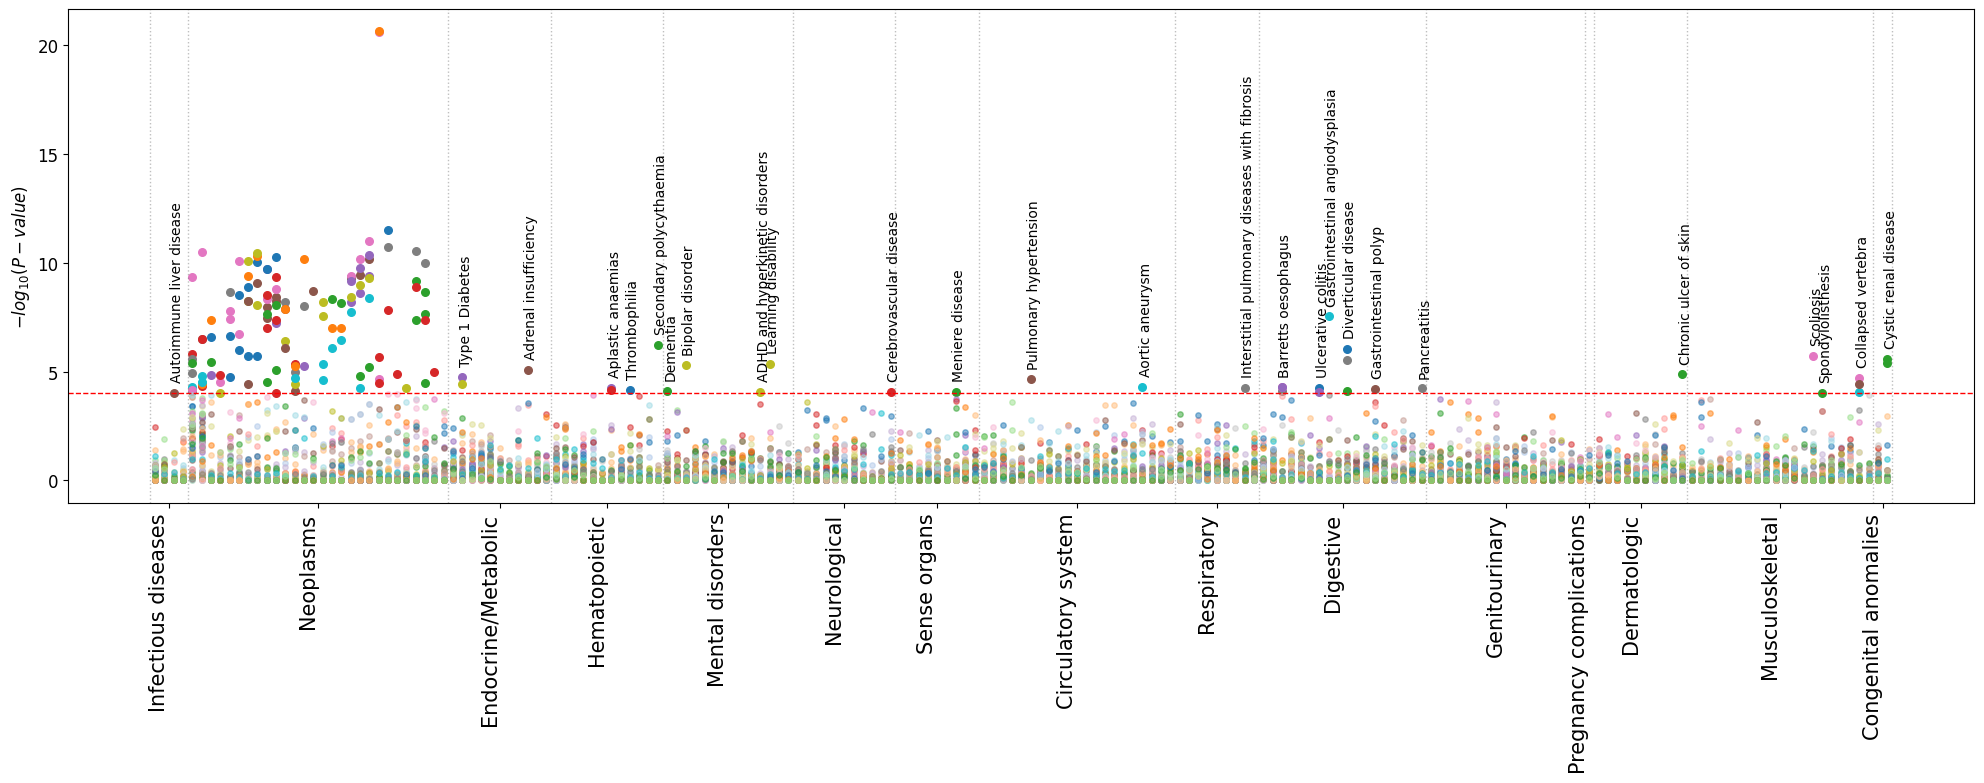

In [19]:


# Directory containing PheWAS summary statistics
phewas_dir = manhattan_path+"phewas"

# Find all files matching the pattern *_phewas.csv
phewas_files = [f for f in os.listdir(phewas_dir) if f.endswith("_phewas.csv")]

# Assign a color to each genotype
colors = plt.cm.tab20.colors
genotype_color_map = {}

# Prepare the plot
plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 12})
df_merged = pd.DataFrame()

for i, file in enumerate(phewas_files):
    df = pd.read_csv(os.path.join(phewas_dir, file))
    genotype = df['snp'].iloc[0] if 'snp' in df.columns else file.replace("_phewas.csv", "")
    color = colors[i % len(colors)]
    genotype_color_map[genotype] = color
    df = df.sort_values(['groupnum', 'phenotype']).reset_index(drop=True)
    df['x'] = range(len(df))
   
    df_merged = pd.concat([df_merged,df], axis=0, ignore_index=True) 
    
    not_sig = df[df["p"] > 0.0001]
    plt.scatter(not_sig["x"], -np.log10(not_sig["p"]),  c=[color], s=15, alpha=0.5)
    # Highlight significant associations
    sig = df[df["p"] <= 0.0001]
    plt.scatter(sig["x"], -np.log10(sig["p"]),  s=30, alpha=1.0)


sig = df_merged[df_merged["p"] <= 0.0001]
sig = sig.groupby(['phenotype']).agg({'p': 'min', 'description': 'first', 'groupnum': 'first', 'x': 'first'}).reset_index()
for xi, yi, groupnum, name in zip(sig["x"], sig['p'], sig['groupnum'], sig['description']):
        if groupnum != 2:
            plt.text(xi-0.4,-np.log10(yi)+0.5, str(name), fontsize=10, rotation=90, ha='left', va='bottom')
    

# Draw significance threshold
plt.axhline(-np.log10(0.0001), color='red', linestyle='--', linewidth=1, label='p=0.0001')

# X-ticks: show every group at the center
# Draw vertical lines at group boundaries
if "group" in df_merged.columns:
    group_centers = df_merged.groupby('group')["x"].mean()
    group_boundaries = df_merged.groupby('group')['x'].min().sort_values().values[0:]
    
    plt.xticks(group_centers, group_centers.index, rotation=90, ha='right', fontsize=15)
    for boundary in group_boundaries:
        plt.axvline(boundary - 0.5, color='grey', linestyle=':', linewidth=1,alpha=0.5)
    last_boundary = df_merged.groupby('group')['x'].max().sort_values().values[-1]
    plt.axvline(last_boundary + 0.5, color='grey', linestyle=':', linewidth=1,alpha=0.5)

plt.xlabel(None)

plt.ylabel("$-log_{10}(P-value)$")
#plt.title('Multi-Genotype PheWAS Manhattan Plot')
plt.title(None)
#plt.legend(title='Genotype', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig(plot_path+'publication'+'/phewas_plot_cancer.png', dpi=300, bbox_inches='tight')
plt.show()

#### Visualise comorbidity association study related summaries

Load Comorbidity Mapping Table

In [66]:
# Cancer groups to visualise
cancer_dict = ['All','Solid','Digestive','Colorectal','Haematopoietic','Lymphoma','Breast','Gynaecological','Ovarian', 'Uterine', 'Cervical',
            'Male Genital','Prostate', 'Urinary','Kidney', 'Bladder','Skin', 'Non-Melanoma Skin', 'Endocrine','Thyroid','Respiratory','Lung',"Secondary"]
# Load mapping file to translate morbidity codes to display-friendly names
morbid_map = pd.read_csv(result_path+"comorbidity"+"/morbidity_map.txt", header=None)
morbid_map.columns = ["term","display"]
# Convert mapping table into a lookup dictionary
morbid_map = dict(zip(morbid_map["term"], morbid_map["display"]))

Plot Top Comorbidities per Cancer Type

In [ ]:
# Load morbidity proportions per cancer type
incidence = pd.read_csv(result_path+"comorbidity"+"/cancer_morbidity.prop.csv",header=0)
incidence["cancer"] = incidence["cancer"].replace({"Haematological":"Haematopoietic","Male genital":"Male Genital"})

# Loop through each cancer type to generate bar plots of top comorbidities
for c in cancer_dict:
    df = incidence[incidence.cancer == c]
    df = df[~df["morbidity"].str.contains("Malignancy")]
    df["total_perc"] = df["total_perc"] * 100
    df["pre_diag_perc"] = df["pre_diag_perc"] * 100
    df.sort_values(by="total", ascending=False, inplace=True)
    df = df.iloc[:20]
    df["morbidity"] = df["morbidity"].apply(lambda x: morbid_map[x])
    plt.figure(figsize=(8,5), dpi=96)
    # Plot total lifetime prevalence (bottom bars)
    bar1 = sns.barplot(df, y="morbidity", x="total_perc", color="lightgreen")
    # Overlay pre-diagnosis prevalence (top bars)
    bar2 = sns.barplot(df, y="morbidity", x="pre_diag_perc",  color="darkgreen")
    top_bar = mpatches.Patch(color='darkgreen', label='Pre-cancer')
    bottom_bar = mpatches.Patch(color='lightgreen', label='Lifetime')
    plt.xlabel("Prevalence (%)")
    plt.ylabel(None)
    plt.legend(handles=[top_bar,bottom_bar])
    plt.title(c)
    plt.tight_layout()
    plt.savefig(plot_path+"publication/comorbidity/"+c+".png", dpi=200)

Merge Prediagnosis Comorbidity Odds Ratios with Phenotype Information

In [134]:
df = pd.read_csv(result_path + "comorbidity"+"/cancer_prediag_morbidity_OR.csv", delimiter=',')
pheinfo = pd.read_csv(result_path + "comorbidity" + "/pheinfo.csv",  delimiter=',')
df_comorbidity = df.merge(pheinfo, how='left', left_on='Morbidity', right_on='description')
df_comorbidity.head()

,Cancer,Morbidity,Direction,Cohort,Positive,OR,Lower_CI,Upper_CI,pvalue,phecode,phenotype,description,groupnum,group,color,Unnamed: 6
0,Digestive,Gastrointestinal polyp,morbidity_pre,534|54634,133|1066,6.535364,5.246155,8.141388,6.217579e-63,565.1,Gastroinstetinal_polyp,Gastrointestinal polyp,10,Digestive,chartreuse4,NaN
1,Cervical,Cervical dysplasia,morbidity_pre,137|30319,27|196,36.475818,23.196874,57.356232,1.093005e-54,620.0,Cervical_dysplasia,Cervical dysplasia,11,Genitourinary,black,NaN
2,Digestive,"Liver fibrosis, sclerosis and cirrhosis",morbidity_pre,534|54634,41|131,17.483017,11.778691,25.949901,9.231084e-46,571.0,Liver_fibrosis_sclerosis_and_cirrhosis,"Liver fibrosis, sclerosis and cirrhosis",10,Digestive,chartreuse4,NaN
3,Colorectal,Gastrointestinal polyp,morbidity_pre,241|54634,68|1066,8.371955,6.162456,11.373651,4.476706e-42,565.1,Gastroinstetinal_polyp,Gastrointestinal polyp,10,Digestive,chartreuse4,NaN
4,Endocrine,Non-malignant CNS tumour,morbidity_pre,164|54634,14|89,51.112280,28.061076,93.099254,7.696087e-38,225.0,Non.malignant_tumour_of_brain_central_nervous_...,Non-malignant CNS tumour,2,Neoplasms,darkcyan,NaN


In [136]:
# Cancer groups to visualise
cancer_dict_agg = ['All', 'Solid', 'Digestive', 'Haematolymphatic', 'Male_Genital', 'Urinary','Endocrine','Respiratory']     

cancer_dict_ind = [ 'Breast', 'Colorectal','Lymphoma', 'Ovarian', 'Uterine','Prostate', 'Kidney', 'Bladder','Skin', 'Non-Melanoma_Skin', 'Lung']

cancer_dict = ['All','Solid','Digestive','Colorectal','Haematopoietic','Lymphoma','Breast','Gynaecological','Ovarian', 'Uterine', 'Cervical',
            'Male genital','Prostate', 'Urinary','Kidney', 'Bladder','Skin', 'Non-Melanoma Skin', 'Endocrine','Thyroid','Respiratory','Lung',"Secondary"]     

# Color assgnnment for each aggregated and individual cancer groups
colors = ["#000000","#267CE6", '#2ca02c','#2ca02c','#d62728','#d62728',
          '#e377c2','#e377c2','#e377c2','#e377c2','#e377c2',
         '#9467bd','#9467bd', '#7f7f7f','#7f7f7f', '#7f7f7f', 
         "#d9d619", "#d9d619", "#c617cf","#c617cf", '#17becf','#17becf','#ff0000']

traits = [v.replace('_', ' ') for v in cancer_dict]
color_map = dict(zip(traits,colors))

Plot Significant Comorbidity Associations per Cancer Type

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/187361782.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




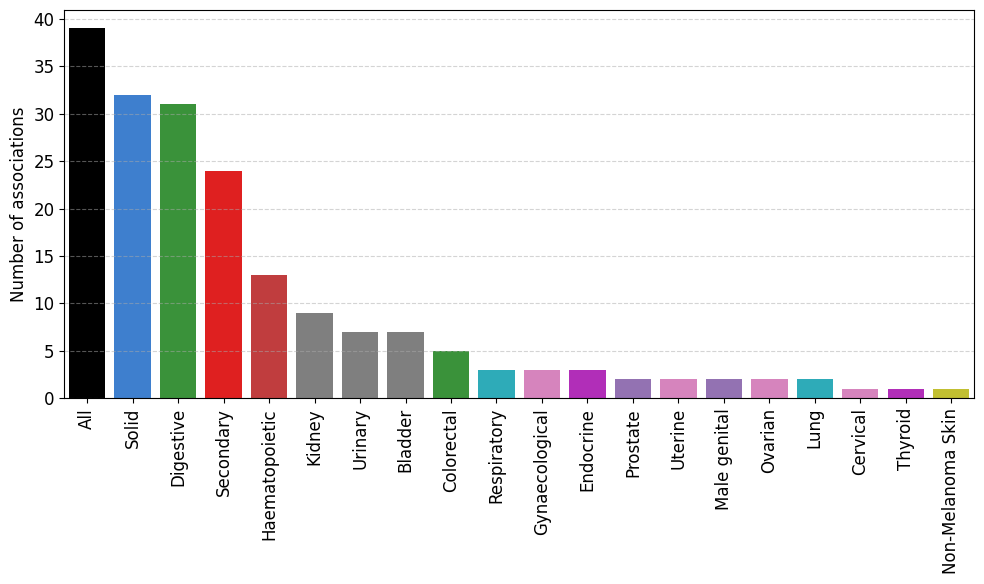

In [137]:
# Filter for statistically significant comorbidity associations (p ≤ 1.5e-5)
df_comorbidity_sig = df_comorbidity[df_comorbidity["pvalue"] <= 0.000015]
# Count the number of significant associations per cancer type
cancer_counts = df_comorbidity_sig['Cancer'].value_counts().sort_values(ascending=False)

# Plot barplot
plt.rcParams.update({'font.size': 12})
bar_colors = [color_map.get(cancer, "#333333") for cancer in cancer_counts.index]

plt.figure(figsize=(10, 6))
plt.grid(axis='y', linestyle='--', color='#aaa', alpha=0.5)
sns.barplot(x=cancer_counts.index, y=cancer_counts.values, palette=bar_colors)

plt.ylabel('Number of associations')
plt.xlabel(None)
plt.title(None)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(plot_path+"publication/comorbidity"+'/comorbidity_occurences.png', dpi=300, bbox_inches='tight')
plt.show()

Multi-Genotype Comorbidity Manhattan Plot

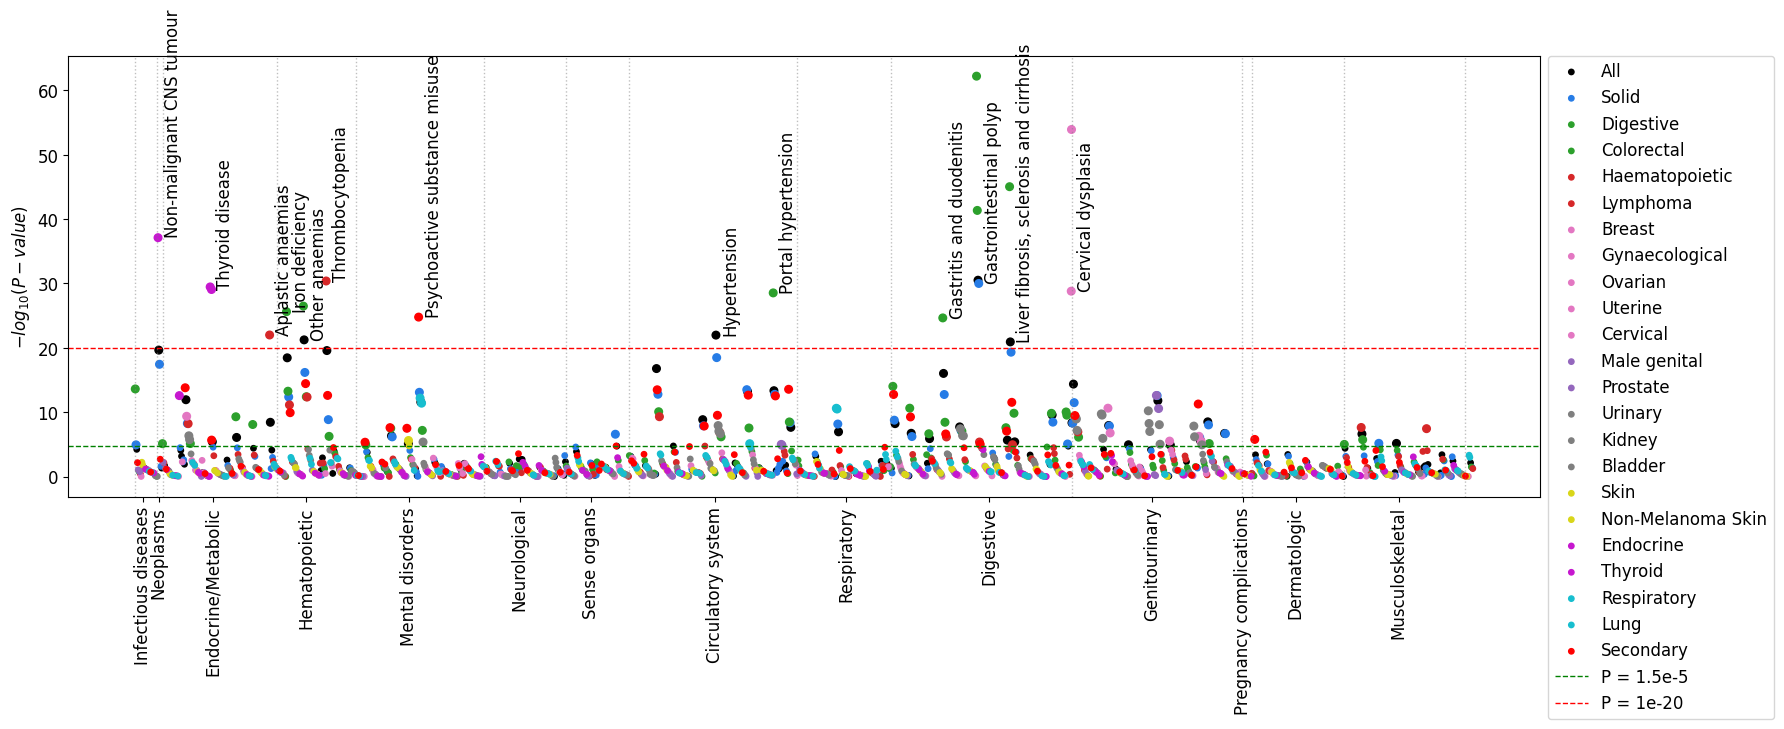

In [138]:

# Assign a color to each genotype
colors = ["#000000","#267CE6", '#2ca02c','#2ca02c','#d62728','#d62728',
          '#e377c2','#e377c2','#e377c2','#e377c2','#e377c2',
         '#9467bd','#9467bd', '#7f7f7f','#7f7f7f', '#7f7f7f', 
         "#d9d619", "#d9d619", "#c617cf","#c617cf", '#17becf','#17becf','#ff0000']

traits = [v.replace('_', ' ') for v in cancer_dict]
genotype_color_map = dict(zip(traits,colors))

# Prepare the plot
plt.figure(figsize=(18, 7))
plt.rcParams.update({'font.size': 12})
df_merged = pd.DataFrame()

df_comorbidity = df_comorbidity.sort_values(['groupnum', 'phenotype']).reset_index(drop=True)
df_comorbidity['x'] = range(len(df_comorbidity))

# Plot comorbidity p-values for each cancer/genotype
for t in traits:
    df = df_comorbidity[df_comorbidity["Cancer"]==t]
    genotype = t
    color = genotype_color_map[genotype]
    df = df.sort_values(['groupnum', 'phenotype']).reset_index(drop=True)
    df['color'] = color
    df_merged = pd.concat([df_merged,df], axis=0, ignore_index=True) 

    not_sig = df[df["pvalue"] > 1.5e-05]
    plt.scatter(not_sig["x"]+2, -np.log10(not_sig["pvalue"]),  c=not_sig["color"], s=15, alpha=1.0, label=genotype)
        # Highlight significant associations
    sig = df[df["pvalue"] <=1.5e-05]
    plt.scatter(sig["x"]+2, -np.log10(sig["pvalue"]),  s=30, alpha=1.0, c=sig["color"], label=None)

# Annotate extremely significant associations (p ≤ 1e-20)
sig = df_merged[df_merged["pvalue"] <= 1e-20]
sig = sig.groupby(['phenotype']).agg({'pvalue': 'max', 'description': 'first', 'groupnum': 'first', 'x': 'first'}).reset_index()
for xi, yi, groupnum, name in zip(sig["x"], sig['pvalue'], sig['groupnum'], sig['description']):
    plt.text(xi+10,-np.log10(yi), str(name), fontsize=12, rotation=90, ha='left', va='bottom')
    

# Draw significance threshold
plt.axhline(-np.log10(1.5e-05), color='green', linestyle='--', linewidth=1, label='P = 1.5e-5')
plt.axhline(-np.log10(1e-20), color='red', linestyle='--', linewidth=1, label='P = 1e-20')

# X-ticks: show every group at the center
# Draw vertical lines at group boundaries
if "group" in df.columns:
    group_centers = df.groupby('group')["x"].mean()
    group_boundaries = df.groupby('group')['x'].min().sort_values().values
    
    plt.xticks(group_centers, group_centers.index, rotation=90)
    for boundary in group_boundaries:
        plt.axvline(boundary-2, color='grey', linestyle=':', linewidth=1,alpha=0.5)
    last_boundary = df.groupby('group')['x'].max().sort_values().values[-1]
    plt.axvline(last_boundary+2 , color='grey', linestyle=':', linewidth=1, alpha=0.5)

plt.xlabel(None)

plt.ylabel("$-log_{10}(P-value)$")
#plt.title('Multi-Genotype PheWAS Manhattan Plot')
plt.title(None)
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.tight_layout()
plt.savefig(plot_path+"publication/comorbidity"+'/comorbidity_manhattan.png', dpi=300, bbox_inches='tight')
plt.show()

##### Summarize Significant Prediagnosis Comorbidity Associations

In [99]:
# Load results of significant prediagnosis comorbidity associations
df_result = pd.read_csv(result_path+"comorbidity"+"/cancer_prediag_morbidity_signif_assoc.csv", header=0)
df_result["Morbidity type"].value_counts()

# Count morbidity types and topographical concordance excluding broad cancer categories (All, Solid, Secondary)
print(df_result[~df_result["Cancer"].isin(["All","Solid","Secondary"])]["Morbidity type"].value_counts())
print(df_result[~df_result["Cancer"].isin(["All","Solid","Secondary"])]["Topographical concordance"].value_counts())

# Cross-tabulation of morbidity type and topographical concordance for filtered cancers
print(df_result.value_counts(["Morbidity type"]))
print(df_result[~df_result["Cancer"].isin(["All","Solid","Secondary"])].groupby(["Morbidity type","Topographical concordance"]).agg({'Odds ratio':['count','mean','std']}))

Morbidity type
Systemic     41
Localised    39
Name: count, dtype: int64
Topographical concordance
Discordant    43
Concordant    37
Name: count, dtype: int64
Morbidity type
Systemic          79
Localised         68
Name: count, dtype: int64
                                         Odds ratio                     
                                              count      mean        std
Morbidity type Topographical concordance                                
Localised      Concordant                        24  7.445417   7.734943
               Discordant                        15  6.906000  12.415564
Systemic       Concordant                        13  8.530000   8.120352
               Discordant                        28  2.602857   0.993333


Stacked Barplot of Morbidity Type per Cancer Site

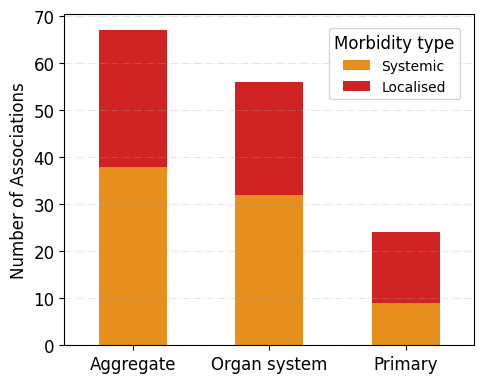

In [ ]:
# Select relevant columns for plotting
df_comorbidity_sig = df_result[["Cancer","Site type", "Morbidity type"]]
# Count occurrences for each Cancer and Morbidity effect
df_bar = df_comorbidity_sig.groupby(['Site type', 'Morbidity type']).size().unstack(fill_value=0)

# Order df_bar by total count (sum across all columns) in descending order
df_bar_ordered = df_bar.loc[df_bar.sum(axis=1).sort_values(ascending=False).index]


morbidity_order = ['Systemic', 'Localised']

# Reorder columns in df_bar_ordered according to morbidity_order (if present)
df_bar_ordered = df_bar_ordered[[col for col in morbidity_order if col in df_bar_ordered.columns]]

# Define color mapping for 'Morbidity effect'
color_map = {
    'Localised': "#cf2222",
    'Systemic': "#e78f1c",
}

# Plot stacked barplot with custom order and colors
ax = df_bar_ordered.plot(
    kind='bar',
    stacked=True,
    figsize=(5, 4),
    color=[color_map[col] for col in df_bar_ordered.columns]
)
ax.set_ylabel('Number of Associations', fontsize=12)
ax.set_title(None)
ax.set_xlabel(None)
ax.legend(loc='upper right', borderaxespad=1, fontsize=10, title='Morbidity type')
ax.grid(visible=True, axis='y',color='#aaa',linestyle='-.', alpha=0.3)
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(plot_path+"publication/comorbidity"+"/morbidity_effect_barplot.png", bbox_inches='tight', dpi=300)
plt.show()

Strip Plot of Log-Odds Ratios by Morbidity Type and Topographical Concordance

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/1775053783.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



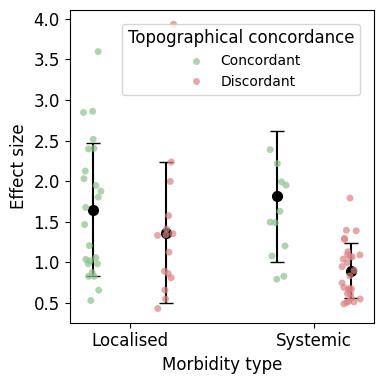

In [100]:
# Filter out specific aggregated cancer categories
df_result_nonagg = df_result[~df_result["Cancer"].isin(["All","Solid","Secondary"])]
# Convert Odds Ratios to log scale (Beta) for effect size
df_result_nonagg["Beta"] = df_result_nonagg["Odds ratio"].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Create strip plot with jitter and dodge by Topographical concordance
plt.figure(figsize=(4, 4))

sns.stripplot(
    data=df_result_nonagg,
    x="Morbidity type",
    y="Beta",
    hue="Topographical concordance",
    dodge=True,
    jitter=True,
    alpha=0.7,
    palette={"Concordant": "#8DC18D", "Discordant": "#dd8282"}
)

# Calculate group-wise mean and standard deviation
grouped = df_result_nonagg.groupby(["Morbidity type", "Topographical concordance"])["Beta"]
means = grouped.mean()
stds = grouped.std()

# Overlay mean ± SD error bars for each group
for i, morbidity in enumerate(df_result_nonagg["Morbidity type"].unique()):
    for j, concordance in enumerate(df_result_nonagg["Topographical concordance"].unique()):
        if (morbidity, concordance) in means.index:
            mean = means[(morbidity, concordance)]
            std = stds[(morbidity, concordance)]
            # Offset for dodge
            offset = -0.2 if concordance == "Concordant" else 0.2
            plt.errorbar(
                i + offset, mean, yerr=std, fmt='o', color='black', capsize=5, markersize=7
            )

plt.ylabel("Effect size")
plt.xlabel("Morbidity type")
plt.legend(title="Topographical concordance", borderaxespad=1, loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(plot_path+"publication/comorbidity"+"/morbidity_type_effect_OR.png", bbox_inches='tight', dpi=300)
plt.show()

#### Visualise Exome-wide association study related summaries

In [109]:
# Amino acid standard nomenclature mapping
amino_acids = {
    'A': 'Ala',
    'R': 'Arg',
    'N': 'Asn',
    'D': 'Asp',
    'C': 'Cys',
    'E': 'Glu',
    'Q': 'Gln',
    'G': 'Gly',
    'H': 'His',
    'I': 'Ile',
    'L': 'Leu',
    'K': 'Lys',
    'M': 'Met',
    'F': 'Phe',
    'P': 'Pro',
    'S': 'Ser',
    'T': 'Thr',
    'W': 'Trp',
    'Y': 'Tyr',
    'V': 'Val'
}

# Helper function to apply mapping
def replace_aa_change(aa_change):
    # Replace only uppercase single-letter codes with 3-letter code (case-sensitive)
    def repl(match):
        before = match.group(1)
        num = match.group(2)
        after = match.group(3)
        finish = match.group(4)
        before_3 = amino_acids.get(before, before)
        after_3 = amino_acids.get(after, after)
        return f"{before_3}{num}{after_3}{finish}"
    # Pattern: single capital, digits, single capital (optionally followed by 'fs')
    pattern = r'^([A-Z])(\d+)([A-Z])(.*)'
    return re.sub(pattern, repl, aa_change)

In [103]:
# Cancer groups to visualise
cancer_dict_agg = ['Solid', 'Digestive', 'Haematological', 'Male_Genital', 'Urinary','Skin', 'Endocrine','Respiratory']     

cancer_dict_ind = [ 'Breast', 'Colorectal','Lymphoma', 'Ovarian', 'Uterine','Prostate', 'Kidney', 'Bladder', 'Non-Melanoma_Skin', 'Lung']

cancer_dict = ['All','Solid','Digestive','Colorectal','Haematopoietic','Lymphoma','Breast','Gynaecological','Ovarian', 'Uterine', 'Cervical',
            'Male_Genital','Prostate', 'Urinary','Kidney', 'Bladder','Skin', 'Non-Melanoma_Skin', 'Endocrine','Thyroid','Respiratory','Lung']     

# Color assgnnment for each aggregated and individual cancer groups
colors = ["#000000","#267CE6", '#2ca02c','#2ca02c','#d62728','#d62728',
          '#e377c2','#e377c2','#e377c2','#e377c2','#e377c2',
         '#9467bd','#9467bd', '#7f7f7f','#7f7f7f', '#7f7f7f', 
         "#d9d619", "#d9d619", "#c617cf","#c617cf", '#17becf','#17becf']

Process Exonic Variant Associations

In [108]:
# Load suggestive loss-of-function or deleterious variant associations
df_set_exonic = pd.read_csv(result_path+"xwas"+"/suggestive_lof_del_poss_association.tab",sep=',')
df_set_exonic[["GENE","AA_CHANGE"]] = df_set_exonic["ALT_ID"].str.split(" ", expand=True)

# Apply custom function to standardize/replace amino acid change notation
df_set_exonic["AA_CHANGE"] = df_set_exonic["AA_CHANGE"].apply(replace_aa_change)
df_set_exonic["ALT_ID"] = df_set_exonic["GENE"] + ":p." + df_set_exonic["AA_CHANGE"]

df_set_exonic[df_set_exonic['GENE']=="ZNF155"]

,#CHROM,POS,ID,REF,ALT,A1FREQ,A1FREQ_CASE,A1FREQ_CTRL,OBS_CT,OBS_CT_CASE,...,TEST,BETA,SE,CHISQ,P,ALT_ID,GENE,CONSEQ,Cancer,AA_CHANGE
2,19,43997046,chr19_43997046_G_GA,G,GA,0.000242,0.006369,0.00019,18565,157,...,ADD,7.02911,1.04541,26.3467,2.853054e-07,ZNF155:p.Ser399LysfsTer5,ZNF155,LoF,Prostate_Cancer,Ser399LysfsTer5


Multi-trait Manhattan Plot for Variant-level Exome-Wide Associsation Study (ExWAS)

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/2901749560.py:29: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/2901749560.py:29: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.



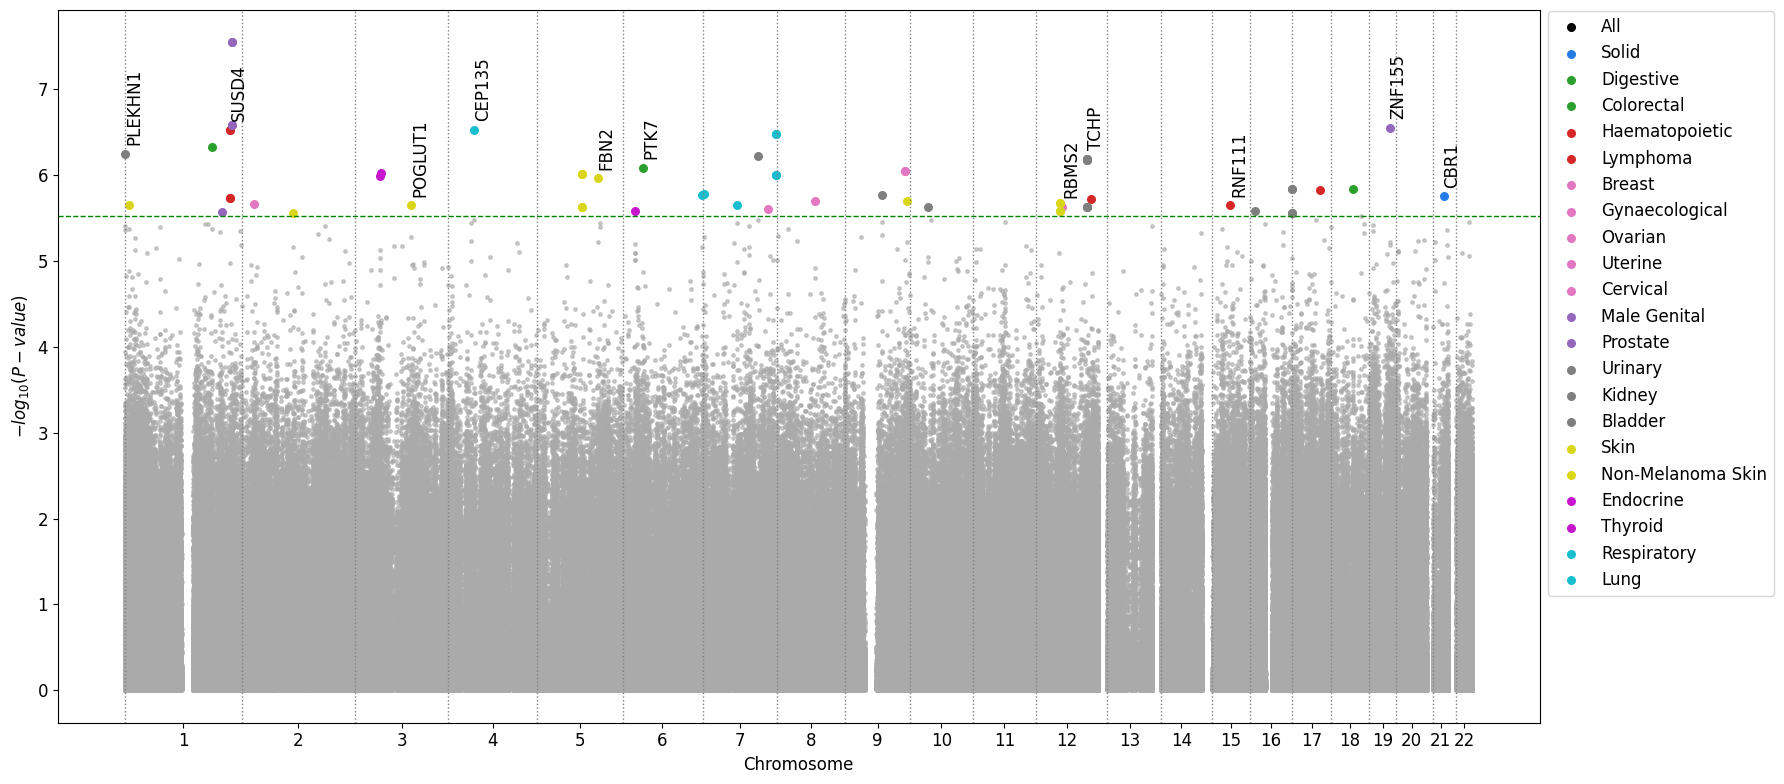

In [ ]:
df_set_exonic = df_set_exonic[["ID","GENE","ALT_ID","CONSEQ"]]

# Define directory containing ExWAS summary statistic files
data_dir = manhattan_path + "xwas/snp"
prefix = "binary_trait_lof_del_poss_"
ext = ".regenie"
gwas_files = [f for f in os.listdir(data_dir) if f.startswith(prefix) and f.endswith(ext)]

# Extract cancer types from filenames
trait_names = [f[len(prefix):-len(ext)].replace("_Cancer","").replace("_"," ") for f in gwas_files]

# Map cancer names to file indices for ordering
agg_to_file = {str(val).replace(" ", "_"): None for val in cancer_dict}
for i, f in enumerate(gwas_files):
    for val in cancer_dict:
        if prefix + str(val).replace(" ", "_") + "_Cancer.regenie" == f:
            agg_to_file[str(val).replace(" ", "_")] = i

# Get the indices in the desired order
ordered_indices = [agg_to_file[str(val).replace(" ", "_")] for val in cancer_dict if agg_to_file[str(val).replace(" ", "_")] is not None]

# Reorder gwas_files, trait_names, and gwas_dfs
gwas_files = [gwas_files[i] for i in ordered_indices]
trait_names = [trait_names[i] for i in ordered_indices]

# Load all ExWAS summary statistics into a list of dataframes
gwas_dfs = []
for file in gwas_files:
    df = pd.read_csv(os.path.join(data_dir, file), sep=' ')
    # Try to find chromosome and position columns
    if 'CHR' not in df.columns:
        if 'CHROM' in df.columns:
            df['CHR'] = df['CHROM']
        elif 'chrom' in df.columns:
            df['CHR'] = df['chrom']
    if 'POS' not in df.columns:
        if 'BP' in df.columns:
            df['POS'] = df['BP']
        elif 'GENPOS' in df.columns:
            df['POS'] = df['GENPOS']
    df['CHR'] = df['CHR'].astype(str)
    df = df[df['CHR'].isin([str(i) for i in range(1, 23)])]
    # Use 'LOG10P' as p-value column
    df['-log10(P)'] = df['LOG10P']
    gwas_dfs.append(df)


# Get all chromosomes present in all files
all_chroms = sorted(set(np.concatenate([df['CHR'].unique() for df in gwas_dfs])), key=lambda x: int(x))


# Calculate cumulative base pair offsets for all chromosomes
chrom_offsets = {}
last_base = 0
for chrom in all_chroms:
    max_bp = max([df[df['CHR'] == chrom]['POS'].max() for df in gwas_dfs if chrom in df['CHR'].unique()])
    chrom_offsets[chrom] = last_base
    last_base += max_bp

# Add cumulative BP to each dataframe
for df in gwas_dfs:
    df['cum_BP'] = df.apply(lambda row: row['POS'] + chrom_offsets[row['CHR']], axis=1)

# Plot
plt.figure(figsize=(18, 8))
plt.rcParams.update({'font.size': 12})

exome_sig = -np.log10(3e-6)
sig_merged = pd.DataFrame()

# Plot each trait ExWAS
for idx, (df, trait) in enumerate(zip(gwas_dfs, trait_names)):
    # Points below significance
    nonsig = df[ df['-log10(P)'] < exome_sig]
    plt.scatter(nonsig['cum_BP'], nonsig['-log10(P)'], s=6, color="#aaa", alpha=0.6, label=None)
    # Points above significance
    sig = df[ df['-log10(P)'] >= exome_sig]
    sig = sig.merge(df_set_exonic, on="ID", how="left")
    sig_merged = pd.concat([sig_merged,sig], axis=0, ignore_index=True) 
    plt.scatter(sig['cum_BP'], sig['-log10(P)'], s=30, color=colors[idx], alpha=1.0, label=trait)

# Annotate genes with extreme significance, excluding 'possMissense'
sig = sig_merged.groupby(['GENE']).agg({'-log10(P)': 'max', 'cum_BP': 'first','CONSEQ':'first'}).reset_index()
for xi, yi, name,conseq in zip(sig['cum_BP'], sig['-log10(P)'], sig['GENE'],sig['CONSEQ']):
        if conseq != "possMissense":
            plt.text(xi, yi+0.1, str(name),  rotation=90, ha='left', va='bottom')

plt.axhline(-np.log10(3e-6), color='green', linestyle='--', linewidth=1)

# Configure x-axis with chromosome centers and boundaries
chrom_centers = []
chrom_boundaries = []
for chrom in all_chroms:
    chrom_df = gwas_dfs[0][gwas_dfs[0]['CHR'] == chrom]
    if not chrom_df.empty:
        center = (chrom_df['cum_BP'].min() + chrom_df['cum_BP'].max()) / 2
        boundary = chrom_df['cum_BP'].min()
    else:
        center = chrom_offsets[chrom] + max([df[df['CHR'] == chrom]['POS'].max() for df in gwas_dfs if chrom in df['CHR'].unique()]) / 2
    chrom_centers.append(center)
    chrom_boundaries.append(boundary)
plt.xticks(chrom_centers, all_chroms)
for boundary in chrom_boundaries:
    plt.axvline(boundary, color='grey', linestyle=':', linewidth=1)

plt.xlabel('Chromosome')
plt.ylabel("$-log_{10}(P-value)$")
plt.title(None)
plt.legend(bbox_to_anchor=(1, 1.01), loc='upper left')
plt.tight_layout()
plt.savefig(plot_path+'publication/xwas'+'/manhattan_plot_xwas_snp.png', dpi=300, bbox_inches='tight')
plt.show()

Multi-trait Manhattan Plot for Gene-level Exome-Wide Associsation Study (ExWAS)

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/743731346.py:27: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/743731346.py:27: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/743731346.py:27: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/743731346.py:27: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/743731346.py:27: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/743731346.

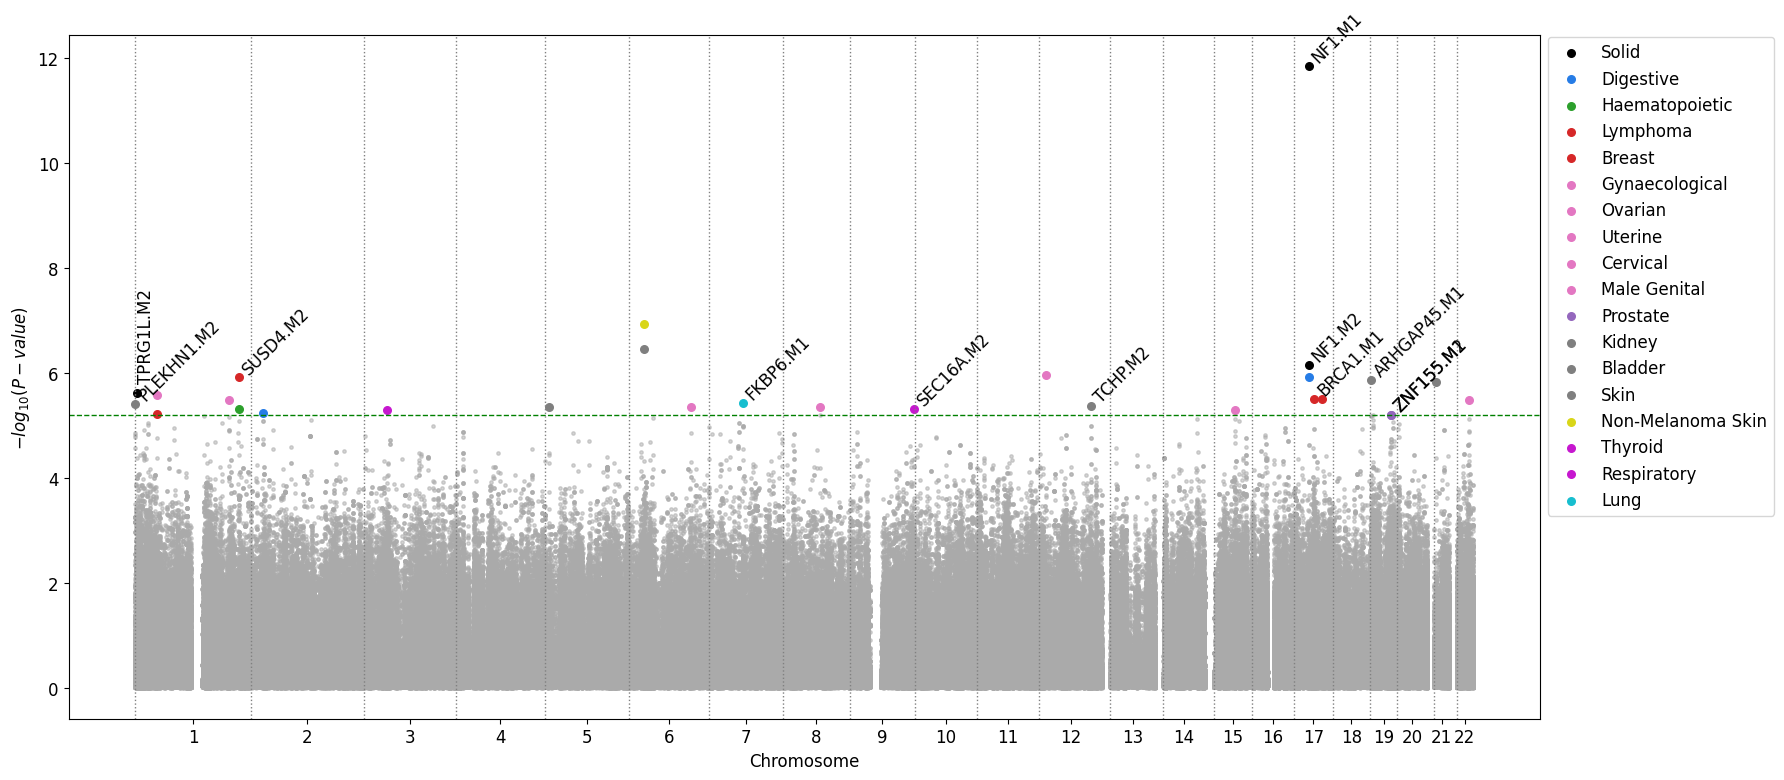

In [112]:
# Define directory containing ExWAS summary statistic files
data_dir = manhattan_path + "xwas/gene"
prefix = "binary_trait_gene_ns-coding_allmask_inc_allaaf_"
ext = ".regenie"
gwas_files = [f for f in os.listdir(data_dir) if f.startswith(prefix) and f.endswith(ext)]

# Extract cancer types from filenames
trait_names = [f[len(prefix):-len(ext)].replace("_Cancer","").replace("_"," ") for f in gwas_files]

# Map cancer types to file index
agg_to_file = {str(val).replace(" ", "_"): None for val in cancer_dict}
for i, f in enumerate(gwas_files):
    for val in cancer_dict:
        if prefix + str(val).replace(" ", "_") + "_Cancer.regenie" == f:
            agg_to_file[str(val).replace(" ", "_")] = i

# Get the indices in the desired order
ordered_indices = [agg_to_file[str(val).replace(" ", "_")] for val in cancer_dict if agg_to_file[str(val).replace(" ", "_")] is not None]

# Reorder gwas_files, trait_names, and gwas_dfs
gwas_files = [gwas_files[i] for i in ordered_indices]
trait_names = [trait_names[i] for i in ordered_indices]

# Load all GWAS summary statistics into a list of dataframes
gwas_dfs = []
for file in gwas_files:
    df = pd.read_csv(os.path.join(data_dir, file), sep=' ')
    df['CHR'] = df['#CHROM'].astype(str)
    df = df[df['CHR'].isin([str(i) for i in range(1, 23)])]
    # Use 'LOG10P' as p-value column
    df['-log10(P)'] =df['P']
    df = df[['ID','CHR', 'POS', '-log10(P)']]
    gwas_dfs.append(df)


# Get all chromosomes present in all files
all_chroms = sorted(set(np.concatenate([df['CHR'].unique() for df in gwas_dfs])), key=lambda x: int(x))


# Calculate cumulative base pair offsets for all chromosomes
chrom_offsets = {}
last_base = 0
for chrom in all_chroms:
    max_bp = max([df[df['CHR'] == chrom]['POS'].max() for df in gwas_dfs if chrom in df['CHR'].unique()])
    chrom_offsets[chrom] = last_base
    last_base += max_bp

# Add cumulative BP to each dataframe
for df in gwas_dfs:
    df['cum_BP'] = df.apply(lambda row: row['POS'] + chrom_offsets[row['CHR']], axis=1)


# Plot
plt.figure(figsize=(18, 8))
plt.rcParams.update({'font.size': 12})

exome_sig = -np.log10(6.2e-6)
mask_map = {"Mask1":'M1', "Mask2":'M2', "Mask3":'M3'}
sig_merged = pd.DataFrame()

# Plot each trait ExWAS
for idx, (df, trait) in enumerate(zip(gwas_dfs, trait_names)):
    
    # Points below significance
    nonsig = df[ df['-log10(P)'] < exome_sig]
    plt.scatter(nonsig['cum_BP'], nonsig['-log10(P)'], s=6, color="#aaa", alpha=0.5, label=None)
    # Points above significance
    
    sig = df[ df['-log10(P)'] >= exome_sig]
    if sig.shape[0] == 0:
        continue
    sig[["GENE","MASK","PAD","MAX_AAF"]] = sig["ID"].str.split(".", expand=True)
    sig["ALT_ID"] = sig.apply(lambda x: x["GENE"] + "." + mask_map[x["MASK"]], axis=1)
    sig = sig.groupby(['ALT_ID']).agg({'-log10(P)': 'max', 'cum_BP': 'first','MASK':'first'}).reset_index()
    #print(colors[idx], trait)
    #print(sig.shape)
    plt.scatter(sig['cum_BP'], sig['-log10(P)'], s=30, color=colors[idx], alpha=1.0, label=trait)
    sig_merged = pd.concat([sig_merged,sig], axis=0, ignore_index=True)
    

sig = sig_merged.groupby(['ALT_ID']).agg({'-log10(P)': 'max', 'cum_BP': 'first','MASK':'first'}).reset_index()
for xi, yi, name,mask in zip(sig['cum_BP'], sig['-log10(P)'], sig['ALT_ID'],sig['MASK']):
        if(name.startswith("TPRG1L")):
            plt.text(xi, yi+0.2, str(name), rotation=90, ha='left', va='bottom')
        elif mask != "Mask3":
            plt.text(xi, yi, str(name), rotation=45, ha='left', va='bottom')

plt.axhline(-np.log10(6.2e-6), color='green', linestyle='--', linewidth=1)

# Set x-ticks to chromosome centers
chrom_centers = []
chrom_boundaries = []
for chrom in all_chroms:
    chrom_df = gwas_dfs[0][gwas_dfs[0]['CHR'] == chrom]
    if not chrom_df.empty:
        center = (chrom_df['cum_BP'].min() + chrom_df['cum_BP'].max()) / 2
        boundary = chrom_df['cum_BP'].min()
    else:
        center = chrom_offsets[chrom] + max([df[df['CHR'] == chrom]['POS'].max() for df in gwas_dfs if chrom in df['CHR'].unique()]) / 2
    chrom_centers.append(center)
    chrom_boundaries.append(boundary)
plt.xticks(chrom_centers, all_chroms)
for boundary in chrom_boundaries:
    plt.axvline(boundary, color='grey', linestyle=':', linewidth=1)

plt.xlabel('Chromosome')
plt.ylabel("$-log_{10}(P-value)$")
plt.title(None)
plt.legend(bbox_to_anchor=(1, 1.01), loc='upper left')
plt.tight_layout()
plt.savefig(plot_path+'publication/xwas'+'/manhattan_plot_xwas_gene.png', dpi=300, bbox_inches='tight')
plt.show()

Stacked Barplot of CGI Hit Proportions by Cancer Type

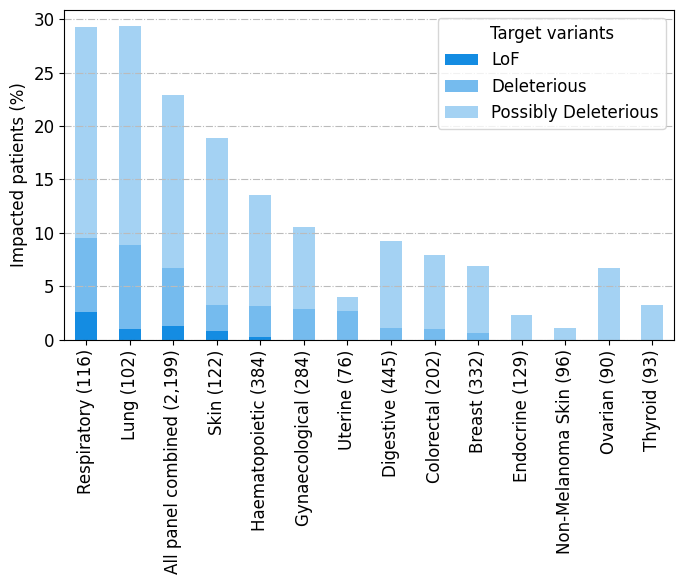

In [116]:
# Load CGI hit counts per cancer
df_counts_sorted = pd.read_csv(result_path+"xwas"+"/cgi_hit_cancer.txt", sep='\t')

# Prepare and filter data
df_counts = df_counts_sorted.copy()
df_counts["cancer"] = df_counts["cancer"].replace({"Haematological":"Haematopoietic","Male genital":"Male Genital"})
df_counts = df_counts[df_counts["cancer"]!="All"]
df_counts["cancer"] = df_counts["cancer"].str.replace("Any","All panel combined")
df_counts = df_counts[df_counts["action"]=="Non-responsive"]
df_counts["group"] = df_counts.apply(lambda x: f'{x["cancer"]} ({x["sample_count"]:,d})', axis=1)
df_counts = df_counts[["group","consequence","hit_prop"]]

# Pivot to get cumulative values for stacked plotting
df_pivot_cum = df_counts.pivot(index='group', columns='consequence', values='hit_prop').fillna(0)
df_pivot_cum = df_pivot_cum[df_pivot_cum['LoF+Deleterious+Possibly Deleterious']!=0.0]

# Compute non-cumulative (individual) contributions for proper stacking
df_stacked = df_pivot_cum.copy()
df_stacked['LoF'] = df_pivot_cum['LoF']
df_stacked['Deleterious'] = df_pivot_cum['LoF+Deleterious'] - df_pivot_cum['LoF']
df_stacked['Possibly Deleterious'] = df_pivot_cum['LoF+Deleterious+Possibly Deleterious'] - df_pivot_cum['LoF+Deleterious']

# Order cancers by combined LoF+Deleterious proportion
cancer_order_by_X = df_pivot_cum['LoF+Deleterious'].sort_values(ascending=False).index.tolist()
df_stacked_ordered = df_stacked.loc[cancer_order_by_X]

# Define colors for each variant category
colors_map = {'LoF': "#148ce2", 'Deleterious': "#148ce295", 'Possibly Deleterious': "#148ce262"}  

# Plot stacked bar chart
ax = df_stacked_ordered[['LoF', 'Deleterious', 'Possibly Deleterious']].plot(kind='bar', stacked=True, color=[colors_map['LoF'], colors_map['Deleterious'], colors_map['Possibly Deleterious']], figsize=(7, 6))
ax.set_ylabel('Impacted patients (%)')
ax.set_xlabel(None)
plt.xticks(rotation=90, ha='center')
plt.legend(title='Target variants', borderaxespad=0.5)
plt.grid(visible=True, axis='y',color='#bbb',linestyle='-.')
plt.tight_layout()
plt.savefig(plot_path+"publication/xwas"+"/cgi_hit_cancer.png",dpi=600)
plt.show()

Lollipop Plot of PanelApp Germline Gene Panel Postiive Predictive Value by Cancer

In [120]:
# Get analytical cohort count for each cancer type
df_cohort = pd.read_csv(result_path+"xwas"+"/cancer_stat.xwas.csv")
df_cohort.columns = ['cancer','control','case']
df_cohort["cancer"] = df_cohort["cancer"].str.replace("_Cancer","")
df_cohort["cancer"] = df_cohort["cancer"].str.replace("_"," ")
df_cohort["cancer"] = df_cohort["cancer"].replace({"Haematological":"Haematopoietic"})
df_cohort.head()

,cancer,control,case
0,All,41263,2199
1,Solid,41263,1846
2,Digestive,41263,445
3,Haematopoietic,41263,384
4,Breast,22852,332


/var/folders/9w/6mtg0vsd4mq5n0t0hfwdz9j40000gp/T/ipykernel_32802/156316501.py:15: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



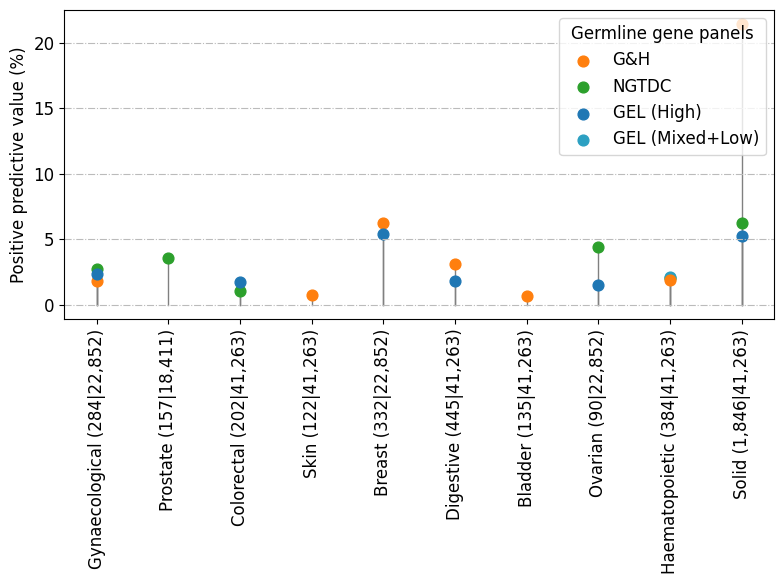

In [122]:
# Load PanelApp efficacy results
df_result = pd.read_csv(result_path+"xwas"+"/panelapp_efficacy_ind.csv",header=0)
df_result["cancer"] = df_result["cancer"].replace({"Haematological":"Haematopoietic","Male genital":"Male Genital"})

# Merge with cohort data for case/control counts
df_result = df_result.merge(df_cohort, on="cancer", how="left")
df_result["group"] = df_result.apply(lambda x: f'{x["cancer"]} ({x["case"]:,d}|{x["control"]:,d})', axis=1)

# Filter for significant results and exclude 'lof_del_poss' consequence
df_result = df_result[df_result["pvalue"]<=0.05]
df_result = df_result[df_result["consequence"]!= "lof_del_poss"]

# Convert PPV to percentage and aggregate maximum per group/status
df_result["PPV"] = df_result["PPV"]*100
df_result = df_result.groupby(["group","status"]).agg({'PPV':max}).reset_index()
unique_tests = list(set(df_result["status"]))

colors_map = {'G&H': '#ff7f0e', 'NGTDC': '#2ca02c', 'GEL (High)': '#1f77b4', 'GEL (Mixed+Low)': '#2ca0c2'}  # or use your colors_map if defined

# Map cancer groups to x-axis positions
cancers = df_result["group"]
cancer_order = list(set(cancers))
x_positions = {cancer: i for i, cancer in enumerate(cancer_order)}
x = [x_positions[c] for c in cancers]
y = df_result["PPV"].to_list()
color_list = [colors_map[t] for t in df_result["status"]]

plt.figure(figsize=(8, 6))
# Plot points per test status
for t in unique_tests:
    idx = [i for i, val in enumerate(df_result["status"]) if val == t]
    plt.scatter([x[i] for i in idx], [y[i] for i in idx], label=t, color=colors_map[t], s=60)

# Draw lollipop stems (grey lines) from 0 to each point
for xi, yi in zip(x, y):
    plt.plot([xi, xi], [0, yi], color='grey', linewidth=1, zorder=0)

plt.xticks(range(len(cancer_order)), cancer_order,rotation=90, ha='center')

#plt.xlabel('Cancer')
plt.ylabel('Positive predictive value (%)')
#plt.title('Odds Ratios by Cancer and Test')

# reordering the legend labels
handles, labels = plt.gca().get_legend_handles_labels()
# specify order based labels value
order = [2,0,3,1]
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order],title='Germline gene panels', loc='upper right')
plt.grid(visible=True, axis='y',color='#bbb',linestyle='-.')
plt.tight_layout()
plt.savefig(plot_path+"publication/xwas"+"/panelapp_efficacy.png", dpi=500)
plt.show()

#### Visualise Phenome-wide association study related summaries

Multi-Genotype PheWAS Manhattan Plot

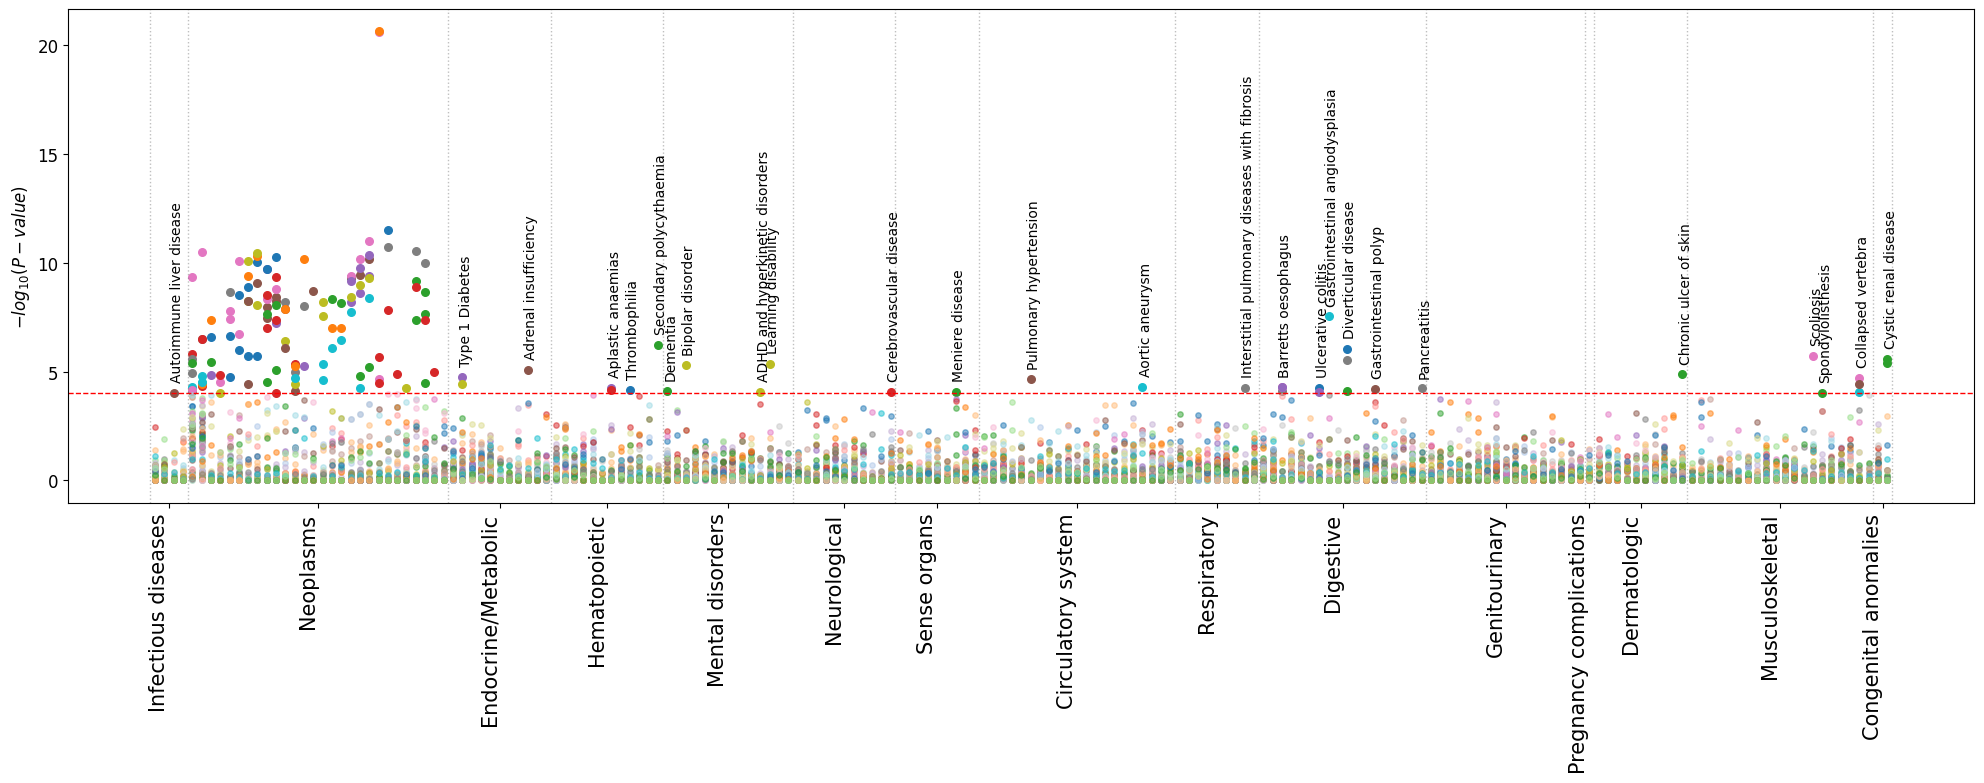

In [ ]:
# Directory containing PheWAS summary statistics
phewas_dir = manhattan_path+"phewas"

# List all PheWAS CSV files
phewas_files = [f for f in os.listdir(phewas_dir) if f.endswith("_phewas.csv")]

# Prepare color map for each genotype
colors = plt.cm.tab20.colors
genotype_color_map = {}

# Prepare the plot
plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 12})
df_merged = pd.DataFrame()

# Loop through each file to plot
for i, file in enumerate(phewas_files):
    df = pd.read_csv(os.path.join(phewas_dir, file))
    genotype = df['snp'].iloc[0] if 'snp' in df.columns else file.replace("_phewas.csv", "")
    color = colors[i % len(colors)]
    genotype_color_map[genotype] = color
    df = df.sort_values(['groupnum', 'phenotype']).reset_index(drop=True)
    df['x'] = range(len(df))
   
    df_merged = pd.concat([df_merged,df], axis=0, ignore_index=True) 
    
    not_sig = df[df["p"] > 0.0001]
    plt.scatter(not_sig["x"], -np.log10(not_sig["p"]),  c=[color], s=15, alpha=0.5)
    # Highlight significant associations
    sig = df[df["p"] <= 0.0001]
    plt.scatter(sig["x"], -np.log10(sig["p"]),  s=30, alpha=1.0)

# Annotate most significant points (p <= 0.0001), skipping neoplasm group
sig = df_merged[df_merged["p"] <= 0.0001]
sig = sig.groupby(['phenotype']).agg({'p': 'min', 'description': 'first', 'groupnum': 'first', 'x': 'first'}).reset_index()
for xi, yi, groupnum, name in zip(sig["x"], sig['p'], sig['groupnum'], sig['description']):
        if groupnum != 2:
            plt.text(xi-0.4,-np.log10(yi)+0.5, str(name), fontsize=10, rotation=90, ha='left', va='bottom')
    

# Draw significance threshold
plt.axhline(-np.log10(0.0001), color='red', linestyle='--', linewidth=1, label='p=0.0001')

# X-ticks: show every group at the center
# Draw vertical lines at group boundaries
if "group" in df_merged.columns:
    group_centers = df_merged.groupby('group')["x"].mean()
    group_boundaries = df_merged.groupby('group')['x'].min().sort_values().values[0:]
    
    plt.xticks(group_centers, group_centers.index, rotation=90, ha='right', fontsize=15)
    for boundary in group_boundaries:
        plt.axvline(boundary - 0.5, color='grey', linestyle=':', linewidth=1,alpha=0.5)
    last_boundary = df_merged.groupby('group')['x'].max().sort_values().values[-1]
    plt.axvline(last_boundary + 0.5, color='grey', linestyle=':', linewidth=1,alpha=0.5)

plt.xlabel(None)

plt.ylabel("$-log_{10}(P-value)$")
#plt.title('Multi-Genotype PheWAS Manhattan Plot')
plt.title(None)
#plt.legend(title='Genotype', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig(plot_path+'publication/phewas'+'/phewas_plot_cancer.png', dpi=300, bbox_inches='tight')
plt.show()

#### Adding gnomAD frequency information for suggestive ExWAS coding variants

In [ ]:
# Read gnomAD freqeuncy data
df_gnomad = pd.read_csv(manhattan_path + "xwas" + "/gnomAd_frequency.txt", sep='\t')
df_gnomad.columns = ["ID","AN","AC","AF","eas_AN","eas_AC","eas_AF","nfe_AN","nfe_AC","nfe_AF","sas_AN","sas_AC","sas_AF","afr_AN","afr_AC","afr_AF"]
df_gnomad.head()

,ID,AN,AC,AF,eas_AN,eas_AC,eas_AF,nfe_AN,nfe_AC,nfe_AF,sas_AN,sas_AC,sas_AF,afr_AN,afr_AC,afr_AF
0,chr1_925935_G_A,1459098,146,1.000620e-04,39700,106,0.00267,1111706,27,0.000024,86238,6,0.000070,33478,2,0.00006
1,chr1_925949_A_C,1459650,4,2.740380e-06,39698,0,0.00000,1111858,0,0.000000,86256,4,0.000046,33478,0,0.00000
2,chr1_925949_A_G,1459650,1,6.850960e-07,39698,0,0.00000,1111858,0,0.000000,86256,0,0.000000,33478,0,0.00000
3,chr1_925956_C_T,1459724,9,6.165550e-06,39700,0,0.00000,1111880,5,0.000004,86256,0,0.000000,33480,1,0.00003
4,chr1_925972_C_T,1459862,1,6.849960e-07,39700,0,0.00000,1111924,0,0.000000,86258,1,0.000012,33478,0,0.00000


In [ ]:
# Merge gnomAD Overall and South Asian freuency data for suggestive SNPs on whole cohort
df = pd.read_csv(result_path + "xwas" + "/suggestive_lof_del_poss_association.tab")
df = df.merge(df_gnomad[["ID","AF","sas_AF"]], on="ID", how="left")
df.to_csv(text_path + "xwas" + "/suggestive_lof_del_poss_association_gnomad_af.txt", sep='\t', index=False)

In [ ]:
# Merge gnomAD Overall and South Asian freuency data for suggestive SNPs on Bangladeshi and Pakistani subgroups
df_result = pd.DataFrame()
for anc in ['Bangladeshi','Pakistani']:
    df = pd.read_csv(f"{result_path}xwas/suggestive_{anc}_lof_del_poss_association.tab")
    df = df.merge(df_gnomad[["ID","AF","sas_AF"]], on="ID", how="left")
    df_result = pd.concat([df_result,df], ignore_index=True)
df_result.to_csv(text_path + "xwas" + "/suggestive_Bangladeshi_Pakistani_lof_del_poss_association_gnomad_af.txt", sep='\t', index=False)

#### GEL output processing

Aggregate Variant Association Results Across Comparisons

In [ ]:
df_final = pd.DataFrame()
# Loop through each comparison and read the corresponding logistic model results
for comp in ['All_Eur_v_All_BP','All_SA_v_All_BP','Solid_Eur_v_Solid_BP','Solid_SA_v_Solid_BP','Breast_Eur_v_Breast_BP','Breast_SA_v_Breast_BP']:
    df = pd.read_csv(result_path+"xwas"+ "/GEL/Variant/logistic_model_M3_"+comp+"_vars_symbols.tsv", sep="\t", skiprows=1, header=None)
    df["comparison"] = comp
    df_final = pd.concat([df_final, df], axis=0, ignore_index=True)

# Read one file with headers to assign column names
df = pd.read_csv(result_path+"xwas"+ "/GEL/Variant/logistic_model_M3_"+comp+"_vars_symbols.tsv", sep="\t")
df_final.columns = df.columns.append(pd.Index(['comparison']))

# Compute minor allele counts and sample sizes
df_final.columns.values[3:9] = ['control_hom','control_het','control_ref','case_hom','case_het','case_ref']
df_final['control_mac'] = df_final['control_het'] + 2*df_final['control_hom']
df_final['case_mac'] = df_final['case_het'] + 2*df_final['case_hom']
df_final['control_n'] = df_final['control_hom'] + df_final['control_het'] + df_final['control_ref']
df_final['case_n'] = df_final['case_hom'] + df_final['case_het'] + df_final['case_ref']
df_final['mac'] = df_final['case_mac'] + df_final['control_mac']
# Filter and sort by minor allele count
df_final.sort_values(by=['mac'], ascending=False, inplace=True)
df_final = df_final[df_final['mac']>=3]

df_final.to_csv(text_path+"xwas"+ "/GEL_variant_associations.tsv", sep='\t', index=False)

Aggregate and Filter Significant Gene-Based Association Results

In [148]:
# Load reference gene list (from ExWAS step) and split ID into components
df_ref = pd.read_csv(result_path+"xwas"+ "/GEL/Gene/reference_genes.txt", sep="\t")
df_ref[["GENE","Mask","PAD","MAXAAF"]] = df_ref["ID"].str.split(".", expand=True)
df_ref_unique = df_ref[["Gene","Mask"]].drop_duplicates()

df_final = pd.DataFrame() 

# Loop over cancer types and comparisons to read gene-based logistic regression results
for cancer in ["All","Solid","Breast"]:
    for comp in ['Eur_v_BP','SA_v_BP']:
        df = pd.read_csv(result_path+"xwas"+ "/GEL/Gene/logistic_model_all_masks_maf_filter_"+cancer+"_"+comp+"_genes_symbols 1.tsv", sep="\t", skiprows=1, header=None)
        df["cancer"] = cancer
        df["comparison"] = comp
        df_final = pd.concat([df_final, df], axis=0, ignore_index=True)

# Read one file with headers to assign column names
df = pd.read_csv(result_path+"xwas"+ "/GEL/Gene/logistic_model_all_masks_maf_filter_"+cancer+"_"+comp+"_genes_symbols.tsv", sep="\t")
df_final.columns = df.columns.append(pd.Index(['cancer','comparison']))

# Compute minor allele counts and sample sizes
df_final.columns.values[3:9] = ['control_hom','control_het','control_ref','case_hom','case_het','case_ref']
df_final['control_mac'] = df_final['control_het'] + 2*df_final['control_hom']
df_final['case_mac'] = df_final['case_het'] + 2*df_final['case_hom']
df_final['control_n'] = df_final['control_hom'] + df_final['control_het'] + df_final['control_ref']
df_final['case_n'] = df_final['case_hom'] + df_final['case_het'] + df_final['case_ref']
df_final['mac'] = df_final['case_mac'] + df_final['control_mac']
df_final.sort_values(by=['mac'], ascending=False, inplace=True)

# Fix gene symbol naming
df_final["Gene_symbol"] = df_final["Gene_symbol"].str.replace("CIMIP2C","FAM166C")

# Filter significant associations: gene in reference list, mac >= 3, p-value <= 0.05
df_sig = df_final[df_final["Gene_symbol"].isin(df_ref["Gene"]) & (df_final["mac"]>=3) & (df_final["p.val.sex"]<=0.05)]

# Merge with reference to identify overlapping genes/masks
df_sig = df_sig[["Gene_symbol","Mask","cancer","comparison","mac","case_n","control_n","case_mac","control_mac","log.odds.ratio.sex", "lower.CI.sex", "upper.CI.sex","p.val.sex","log.odds.ratio", "lower.CI", "upper.CI","p.val"]]
df_sig_overlap = df_sig.merge(
    df_ref_unique[["Gene", "Mask"]],
    left_on=["Gene_symbol", "Mask"],
    right_on=["Gene", "Mask"],
    how="inner"
)

# Sort and format output
df_sig_overlap.sort_values(by=["Gene_symbol","Mask","cancer"], inplace=True)
df_sig_overlap["mac"] = df_sig_overlap["case_mac"].astype(str)+"|"+df_sig_overlap["control_mac"].astype(str)
df_sig_overlap["cohort"] = df_sig_overlap["case_n"].astype(str)+"|"+df_sig_overlap["control_n"].astype(str)
df_sig_overlap["CI.sex"] = df_sig_overlap["lower.CI.sex"].map(lambda x: f"{x:.2f}") + " - " + df_sig_overlap["upper.CI.sex"].map(lambda x: f"{x:.2f}")
df_sig_overlap[["Gene_symbol","Mask","cancer","comparison","mac","cohort","log.odds.ratio.sex", "lower.CI.sex","upper.CI.sex","p.val.sex"]].to_csv(text_path+"xwas"+ "/GEL_significant_gene_associations.txt", sep="\t", index=False)